In [1]:
import numpy as np

In [2]:
from src.utils.input import *
%run "docs\src\utils\notebook_style.ipynb"


In [3]:
params_krummung, params_zustandslinien, Laststufen = load_params_SV14()

In [4]:
params = dict(params_krummung)
params.update(params_zustandslinien)

params_plot = param_value(params)

# Vierpunktbiegeversuch{#sec-vierpunkt}


Dieses Kapitel zeigt alle in @sec-modellbeschrieb aufgezeigten Modellvorstellungen, angewendet auf einen Vierpunktbiegeversuch. Das Vorgehen ist in grossen Teilen analog dem Berechnungsvorgehen aus dem @sec-dreipunkt. Es wird das Ziel verfolgt, die Anwendbarkeit des Berechnungsapparats an einem weiteren Versuch zu verifizieren, bzw. die Differenzen zwischen den mit den verschiedenen Modellvorstellungen berechneten Verformungen und den gemessenen Verformungen aufzuzeigen.

## Versuchsbeschreibung

Entnommen ist der Versuch SV14 aus @Tue2019. Es handelt sich um einen Vierpunktbiegeversuch. Es wird das Verhalten in Feldmitte analysiert. Im Zugbereich sind Bewehrungsstäbe mit hochfestem Stahl verlegt. Die Schubbewehrung ist minimal gehalten, sowie unterscheidet sich die Teilung im linken und rechten Bereich des Balkens. Die Bewehrung ist stets orthogonal oder parallel zu den Bauteilkanten verlegt. Dargestellt ist dies in @fig-system_sv14.

![Lagerung und Belastung des Balkens, nachgezeichnet nach @Tue2019](../images/versuchsskizze_14.svg){#fig-system_sv14}

Das statische System entspricht einem einfachen Balken. Die Last wird an beiden Angriffspunkten zeit- und betragsgleich eingeleitet. Gemäss den Versuchsdaten tritt ein Biegeversagen bei einer Laststufe von $105 \text{ kN}$ ein. 

![Last-Verformungs-Verlauf des Balkens, entnommen aus @Tue2019](../images/verformungsverlauf_tue.svg){#fig-last_verformung_sv14}

Das Last-Verformungs-Verhalten ist in der @fig-last_verformung_sv14 dargestellt.

## Eigenschaften der Baustoffe

Die Eigenschaften des hochfesten Betonstahls sind aus @annahutte_broschure entnommen. Für den Bst 550 sind Eigenschaften gemäss dem B500B aus der Schweizer Norm @SIA2013a angesetzt mit einer Erhöhung der Fliessgrenze auf $550 \text{ N}/\text{mm}^2$. Lediglich die Betondruckfestigkeit ist im Versuchsbericht @Tue2019 beschrieben. Diese wird als Zielfestigkeit $f_c = 35 \text{ N}/\text{mm}^2$ deklariert. Die Zylinderdruckfestigkeit, sowie Zugefestigkeit und Elastizitätsmodul sind folgend rechnerisch ermittelt. Die Zylinderdruckfestigkeit ist entsprechend gewählt, um die Zielfestigkeit zu erreichen:

In [5]:
eq_f_c = sp.Eq(f_c, 2.7 * f_cc ** sp.Rational(2, 3))
eq_f_c_num = sp.Eq(
    f_c,
    eq_f_c.subs(params).subs(unit.N, 1).subs(unit.mm, 1).rhs * unit.N / unit.mm**2,
)
params[f_c] = eq_f_c_num.rhs
display(eq_f_c, eq_f_c_num.evalf(3))

              2/3
f_c = 2.7⋅f_cc   

      35.0⋅newton
f_c = ───────────
                2
      millimeter 

In [6]:
Eq_list.append(eq_f_c_num)

Die Zugfestigkeit berechnet mittels der Gleichung nach @Jaeger2013 folgt zu:

In [7]:
eq_fct = sp.Eq(f_ct, 0.3 * f_cc ** sp.Rational(2, 3))
eq_fct_num = sp.Eq(
    f_ct, eq_fct.subs(params).evalf(3).rhs.args[0] * unit.N / unit.mm**2
)
params[f_ct] = eq_fct_num.rhs
display(eq_fct, eq_fct_num.evalf(2))

               2/3
f_ct = 0.3⋅f_cc   

        3.9⋅newton
f_ct = ───────────
                 2
       millimeter 

Die Abschätzung für den Elastizitätsmodul nach @Jaeger2013 resultiert zu:

In [8]:
eq_Ec = sp.Eq(E_c, 10000 * f_cc ** sp.Rational(1, 3))
eq_Ec_num = sp.Eq(E_c, eq_Ec.subs(params).evalf(5).rhs.args[0] * unit.N / unit.mm**2)
params[E_c] = eq_Ec_num.rhs
display(eq_Ec, eq_Ec_num)

            3 ______
E_c = 10000⋅╲╱ f_cc 

      36011.0⋅newton
E_c = ──────────────
                 2  
       millimeter   

## Reiner Biegeträger

Die beschriebenen Beziehungen aus dem @sec-kontinua sind folgend auf den Versuch angewendet. Es sind Auflagerkräfte, sowie Zustandslinien der Schnittgrössen dargestellt. Als Grundlage dient das statische System in der @fig-stat_system_14_auflagerbreite. 

![Statisches System des Balkens mit berücksichtigter Auflagerbreite](../images/statisches_system_auflagerbreite_14.svg){#fig-stat_system_14_auflagerbreite}


In [9]:
# | label: tbl-params_reiner_biegetraeger_sv14
# | tbl-cap: Berechnungsparameter der Systemgeometrie


dict_to_table(params_zustandslinien)

|  Parameter  | ​  |
|---|---|
| $a_{1} = 0.2 \text{m}$ | $a_{2} = 1.5 \text{m}$ |
| $a_{3} = 1.0 \text{m}$ | $a_{4} = 1.5 \text{m}$ |
| $a_{5} = 0.2 \text{m}$ | $b = 170.0 \text{mm}$ |
| $b_{Auflager} = 100 \text{mm}$ | $h = 450.0 \text{mm}$ |


### Auflagerkräfte

Die Auflagerkräfte lassen sich anhand der Gleichgewichtsbeziehungen am statisch bestimmten System ermitteln. Die Bestimmung derer ist für den einfachen Balken trivial und entsprechen im Betrag den angreifenden Kräften. In Anlehnung an das Vorgehen beim Dreipunktbiegeversuch im @sec-dreipunkt ist folgend eine Ermittlung durch die Gleichgewichtsbeziehungen gezeigt. Dazu wird zuerst die Gesamtlänge des Balkens berechnet. Dies dient als Kontrollgrösse.

In [10]:
eq_l_tot = sp.Eq(l_tot, a_1 + a_2 + a_3 + a_4 + a_5)
eq_l_tot_num = eq_l_tot.subs(params)
Eq_list.append(eq_l_tot_num)
display(eq_l_tot, eq_l_tot_num.evalf(3))

lₜₒₜ = a₁ + a₂ + a₃ + a₄ + a₅

lₜₒₜ = 4.4⋅meter

In [11]:
Eq_list.append(eq_l_tot_num)

Mittels dem Gleichgewicht der Momente um die Auflagerpunkte $C$ und $B$ folgen die Beziehungen zwischen den Einwirkungen und den Reaktionskräften:



In [12]:
eq_ggw_M_C = sp.Eq(0, -F_A * a_2 - F_A * (a_2 + a_3) - F_C * (a_2 + a_3 + a_4))
eq_ggw_M_B = sp.Eq(0, F_A * (a_4 + a_3) + F_A * a_4 - F_B * (a_2 + a_3 + a_4))


ggw_solve = sp.solve([eq_ggw_M_C, eq_ggw_M_B], [F_C, F_B])


display(eq_ggw_M_C, eq_ggw_M_B)

0 = -F_A⋅a₂ - F_A⋅(a₂ + a₃) - F_C⋅(a₂ + a₃ + a₄)

0 = F_A⋅a₄ + F_A⋅(a₃ + a₄) - F_B⋅(a₂ + a₃ + a₄)

Werden diese nach den Reaktionskräften aufgelöst, folgen die Beziehungen:

In [13]:
eq_F_B = sp.Eq(F_B, ggw_solve[F_B])

eq_F_C = sp.Eq(F_C, ggw_solve[F_C])

display(eq_F_B, eq_F_C)

      F_A⋅a₃ + 2⋅F_A⋅a₄
F_B = ─────────────────
         a₂ + a₃ + a₄  

      -2⋅F_A⋅a₂ - F_A⋅a₃
F_C = ──────────────────
         a₂ + a₃ + a₄   

Die Reaktionskräfte dividiert durch die Auflagerbreite resultieren zu den folgenden Streckenlasten, bzw. Reaktionen:

In [14]:
eq_f_B = sp.Eq(f_B, F_B / b_auflager).subs(F_B, eq_F_B.rhs)


display(eq_f_B)

          F_A⋅a₃ + 2⋅F_A⋅a₄    
f_B = ─────────────────────────
      b_Auflager⋅(a₂ + a₃ + a₄)

In [15]:
eq_f_C = sp.Eq(f_C, F_C / b_auflager).subs(F_C, eq_F_C.rhs)

display(eq_f_C)

          -2⋅F_A⋅a₂ - F_A⋅a₃   
f_C = ─────────────────────────
      b_Auflager⋅(a₂ + a₃ + a₄)

In [16]:
eq_f_A = sp.Eq(f_A, F_A / b_auflager)
display(eq_f_A)

         F_A    
f_A = ──────────
      b_Auflager

### Zustandslinien

Folgend wird anhand der Einwirkung die Zustandslinien der Schnittkräfte bestimmt. Dabei ist zu beachten, dass die Zustandslinien lediglich für die maximal gewählte Laststufe gelten. Der Verlauf der Einwirkungen ist in @fig-q_x_sv14 aufgezeigt.

In [17]:
DGL_biegetraeger = sp.Eq(q_x, -EI_I * sp.Derivative(w, x, 4))

In [18]:
eq_q_x = sp.Eq(
    q_x,
    sp.Piecewise(
        (0, (x > 0) & (x <= (a_1 - b_auflager / 2))),
        (-eq_f_B.rhs, (x > (a_1 - b_auflager / 2)) & (x < (a_1 + b_auflager / 2))),
        (0, (x > (a_1 + b_auflager / 2)) & (x < ((a_1 + a_2) - b_auflager / 2))),
        (
            eq_f_A.rhs,
            (x > ((a_1 + a_2) - b_auflager / 2)) & (x < ((a_1 + a_2) + b_auflager / 2)),
        ),
        (
            0,
            (x > ((a_1 + a_2) + b_auflager / 2))
            & (x < ((a_1 + a_2 + a_3) - b_auflager / 2)),
        ),
        (
            eq_f_A.rhs,
            (x > ((a_1 + a_2 + a_3) - b_auflager / 2))
            & (x < ((a_1 + a_2 + a_3) + b_auflager / 2)),
        ),
        (
            0,
            (x > ((a_1 + a_2 + a_3) + b_auflager / 2))
            & (x < ((a_1 + a_2 + a_3 + a_4) - b_auflager / 2)),
        ),
        (
            eq_f_C.rhs,
            (x > ((a_1 + a_2 + a_3 + a_4) - b_auflager / 2))
            & (x < ((a_1 + a_2 + a_3 + a_4) + b_auflager / 2)),
        ),
        (0, True),
    ),
).simplify()

params_plot = param_value(params)
eq_q_x_num = eq_q_x.subs(params_plot)

In [19]:
Eq_list.append(eq_q_x_num)

In [20]:
x_array = np.linspace(0, np.float64((eq_l_tot.rhs).subs(params_plot)), 4000)


q_x_lamb = sp.lambdify((F_A, x), eq_q_x_num.rhs, "numpy")
q_x_array = []
for Last in Laststufen:
    q_x_array.append(q_x_lamb(Last, x_array))

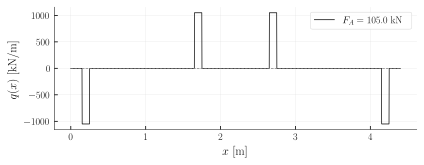

In [21]:
# | label: fig-q_x_sv14
# | fig-cap: Verlauf der Einwirkungen
plt.plot(
    x_array,
    q_x_array[-1] / 1000,
    color="black",
    label=f"$F_A =$ {Laststufen[-1]/1000} kN",
)
plt.plot(x_array, 0 * x_array, color="gray", linestyle="dashed")

plt.xlabel(f"${sp.latex(x)}$ [m]")
plt.ylabel(f"${sp.latex(q_x)}$ [kN/m]")
plt.legend()
plt.savefig("images/q_x_SV14.svg")

plt.show()

Durch Integration der Einwirkung über die Laufvariable $x$ ergibt sich der Verlauf der Querkraft.

$$
V(x) = -\int q(x) \, dx + c_1
$${#eq-vx_integriert_sv14}

Dabei kann mit der Randbedingun $V(0) = 0$ die Integrationskonstante ermittelt werden. Der Verlauf der Querkräfte ist in @fig-v_x_sv14 dargestellt.

In [22]:
eq_V_x = sp.Eq(-V_x, sp.integrate(eq_q_x_num.rhs, x) + c_1)

c_1_num = sp.solve(eq_V_x.rhs.subs(x, 0).subs(params), c_1)[0]

V_x_solve = eq_V_x.subs(c_1, c_1_num).simplify()

V_x_lamb = sp.lambdify((F_A, x), V_x_solve.rhs, "numpy")

V_x_array = []
for Last in Laststufen:
    V_x_array.append(V_x_lamb(Last, x_array))

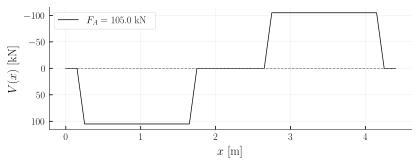

In [23]:
# | label: fig-v_x_sv14
# | fig-cap: Verlauf der Querkräfte

plt.plot(
    x_array,
    V_x_array[-1] / 1000,
    color="black",
    label=f"$F_A =$ {Laststufen[-1]/1000} kN",
)
plt.plot(x_array, 0 * x_array, color="gray", linestyle="dashed")

plt.gca().invert_yaxis()
plt.xlabel(f"${sp.latex(x)}$ [m]")
plt.ylabel(f"${sp.latex(V_x)}$ [kN]")
plt.legend()
plt.savefig("images/V_x_SV14.svg")

plt.show()

Der Verlauf des Biegemoments lässt sich durch die Integration der Querkräfte bestimmen:

$$
M(x) = \int V(x) \, dx + c_2
$${#eq-m_x_sv14}

Mit der Randbedingung $M(0) = 0$ kann die Integrationskonstante bestimmt werden. Der Verlauf der Biegemomente ist in @fig-m_x_sv14 dargestellt. Es stellt sich ein Maximum in der Feldmitte ein.

In [24]:
eq_M_x = sp.Eq(M_x, sp.integrate(V_x_solve.rhs, x) + c_2)
c_2_num = sp.solve(eq_M_x.subs(x, 0).rhs.subs(params), c_2)[0]
M_x_solve = eq_M_x.subs(c_2, c_2_num).simplify()
M_x_lamb = sp.lambdify((F_A, x), M_x_solve.rhs, "numpy")


M_x_array = []
for Last in Laststufen:
    M_x_array.append(M_x_lamb(Last, x_array))

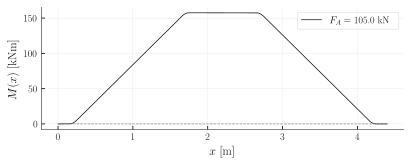

In [25]:
# | label: fig-m_x_sv14
# | fig-cap: Verlauf der Biegemomente

plt.plot(
    x_array,
    M_x_array[-1] / 1000,
    color="black",
    label=f"$F_A =$ {Laststufen[-1]/1000} kN",
)
plt.plot(x_array, 0 * x_array, color="gray", linestyle="dashed")

plt.xlabel(f"${sp.latex(x)}$ [m]")
plt.ylabel(f"${sp.latex(M_x)}$ [kNm]")
plt.legend()
plt.savefig("images/M_x_SV14.svg")

plt.show()

Zusätzlich zu den resultierenden Biegemomenten aus der Einwirkung kann ein durch die Längszugkraft aus der Querkraft induziertes Biegemoment ermittelt werden. Dies wird mit einem Versatzmass berücksichtigt, aufgezeigt in @sec-versatzmass. In @fig-m_x_versatz_sv14 ist die Erhöhung durch das Versatzmass gezeigt. Der notwendige Hebelarm der inneren Kräfte wird anhand der statischen Höhe $d$ abgeschätzt. Dabei werden zuerst die statischen Höhen der unterschiedlichen Zugstäbe gesondert ermittelt.



In [26]:
theta_c3_num = params[theta_c3]  # in Grad

# Berechnung der statischen Höhe für die einzelnen Bewehrungslagen
eq_d_1 = sp.Eq(d_1, h - c_nom - sp.Rational(0.5) * diam_s_1)
eq_d_1_num = eq_d_1.subs(params)
Eq_list.append(eq_d_1_num)


eq_d_2 = sp.Eq(d_2, h - c_nom - sp.Rational(0.5) * diam_s_2)
eq_d_2_num = eq_d_2.subs(params)
Eq_list.append(eq_d_2_num)

# Der Mittelwert der Bewehrungslagen
eq_d_mean = sp.Eq(d, (d_1 + d_2) / 2)
eq_d_mean_num = eq_d_mean.subs(d_1, eq_d_1_num.rhs).subs(d_2, eq_d_2_num.rhs)
Eq_list.append(eq_d_mean_num)

# Abschätzung des inneren Hebelarms anhand der mittleren statischen Höhe
eq_z_schaetzung = sp.Eq(z, 0.9 * d)
eq_z_schaetzung_num = eq_z_schaetzung.subs(d, eq_d_mean_num.rhs)


# Bestimmung des Versatzmasses
h_versatz = (
    abs(V_x) * sp.cot(sp.rad(theta_c3_num)) / 2 * eq_z_schaetzung_num.rhs.args[0] / 1000
)
h_versatz_lamb = sp.lambdify((V_x), h_versatz, "numpy")

h_versatz_array = []
for V_x in V_x_array:
    h_versatz_array.append(h_versatz_lamb(V_x))


display(eq_d_1, eq_d_1_num.evalf(3), eq_d_2, eq_d_2_num.evalf(3))

       \oslash_s,1           
d₁ = - ─────────── - cₙₒₘ + h
            2                

d₁ = 406.0⋅millimeter

       \oslash_s,2           
d₂ = - ─────────── - cₙₒₘ + h
            2                

d₂ = 409.0⋅millimeter

Die statische Höhe im Mittel der beiden Stäbe beträgt:

In [27]:
display(eq_d_mean, eq_d_mean_num.evalf(3))

    d₁   d₂
d = ── + ──
    2    2 

d = 408.0⋅millimeter

Anhand dieser wird der Hebelarm der inneren Kräfte bestimmt:

In [28]:
display(eq_z_schaetzung, eq_z_schaetzung_num.evalf(3))

z = 0.9⋅d

z = 367.0⋅millimeter

Sowie gilt folgende Neigung des Druckfelds. Die Wahl des Winkels entspricht dem unteren Grenzwert der Norm [@SIA2013a, p. 54].

In [29]:
display(Markdown(f"$$\n \\theta_{{c3}} = {theta_c3_num}^{{\\circ}}\n$$" + "{#eq-theta_c3_sv14}"))

$$
 \theta_{c3} = 30.0^{\circ}
$${#eq-theta_c3_sv14}

Damit ist der Verlauf der Biegemomente mit dem Versatzmass definiert.

In [30]:
def calculate_m_c_versatz(mx, versatz):
    mx_sol_list = []
    maximum = max(mx)
    for i in range(0, len(mx)):
        if (mx[i] + versatz[i]) >= maximum:
            mx_sol = maximum

        else:
            mx_sol = mx[i] + versatz[i]
        mx_sol_list.append(mx_sol)

    return mx_sol_list


M_x_array_versatz = []
for i in range(0, len(M_x_array)):
    mx_versetzt = calculate_m_c_versatz(M_x_array[i], h_versatz_array[i])
    M_x_array_versatz.append(np.array(mx_versetzt))

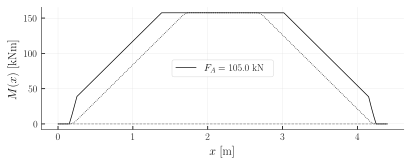

In [31]:
# | label: fig-m_x_versatz_sv14
# | fig-cap: Verlauf der Biegemomente, mit Versatzmass
plt.plot(x_array, M_x_array[-1] / 1000, color="black", linestyle="dotted")
plt.plot(
    x_array,
    M_x_array_versatz[-1] / 1000,
    color="black",
    label=f"$F_A =$ {Laststufen[-1]/1000} kN",
)
plt.plot(x_array, 0 * x_array, color="gray", linestyle="dashed")

plt.xlabel(f"${sp.latex(x)}$ [m]")
plt.ylabel(f"${sp.latex(M_x)}$ [kNm]")
plt.legend()
plt.savefig("images/M_x_versatz_SV14.svg")

plt.show()

In [32]:
eq_phi_x = sp.Eq(phi_x, sp.integrate(M_x_solve.rhs / EI, x) + c_3)

#### Verdrehung- und Verformungslinien

Wie in @sec-kontinua hergeleitet, sind die Gleichgewichtsbetrachtungen nicht ausreichend, um die Verdrehung und Verformung zu beschreiben. Die Werkstoffbeziehung bedingt eine Biegesteifigkeit. Dabei wird von einer konstanten Biegesteifigkeit ausgegangen. Unter der Annahme eines ungerissenen Betonquerschnitts lässt sich die Biegesteifigkeit wie folgt berechnen:

In [33]:
eq_EI = sp.Eq(EI, E_c * b * h**3 / 12)
eq_EI_num = eq_EI.subs(params)

In [34]:
Eq_list.append(eq_EI_num)

In [35]:
display(eq_EI, unit.convert_to(eq_EI_num.evalf(3), [unit.kilonewton, unit.meter]))

            3
     E_c⋅b⋅h 
EI = ────────
        12   

                             2
EI = 4.65e+4⋅kilonewton⋅meter 

Der Verlauf der Verdrehung entspricht dem integrierten Verlauf der Biegemomente, dividiert durch die Biegesteifigkeit.

$$
\varphi(x) = \frac{1}{EI}\int M(x) \, dx + c_3
$${#eq-verdrehung_sv14}

Die Verformung hingegen entspricht dem integrierten Verlauf der Verdrehung.

$$
w(x) = \int -\varphi(x) \, dx + c_4
$${#eq-verformung_sv14}

Mit den Randbedingungen $w(C) = 0$ und $w(B) = 0$ können die Integrationskonstanten bestimmt werden. Der elastische Verformungsverlauf ist in der @fig-w_x_sv14 dargestellt.



In [36]:
eq_w_x = sp.Eq(w_x, -sp.integrate(eq_phi_x.rhs, x) + c_4)
eq_w_x.subs(params_plot)
c_solve = sp.solve(
    [
        eq_w_x.rhs.subs(x, a_1).subs(params_plot),
        eq_w_x.rhs.subs(x, a_1 + a_2 + a_3 + a_4).subs(params_plot),
    ],
    [c_3, c_4],
)


eq_w_x_solve = eq_w_x.subs(c_solve).subs(params_plot)


w_x_lamb = sp.lambdify((F_A, x, EI), eq_w_x_solve.rhs)

In [37]:
w_x_array_ungerissen = []
for Last in Laststufen:
    w_x_array_ungerissen.append(
        w_x_lamb(Last, x_array, np.float64(eq_EI.rhs.subs(params_plot)))
    )

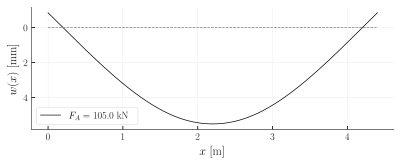

In [38]:
# | label: fig-w_x_sv14
# | fig-cap: Verlauf der Verformung, bestimmt mit einer konstanten ungerissenen Biegesteifigkeit

plt.plot(
    x_array,
    w_x_array_ungerissen[-1] * 1000,
    color="black",
    label=f"$F_A =$ {Laststufen[-1]/1000} kN",
)
plt.plot(x_array, 0 * x_array, color="gray", linestyle="dashed")
plt.gca().invert_yaxis()
plt.xlabel(f"${sp.latex(x)}$ [m]")
plt.ylabel(f"${sp.latex(w_x)}$ [mm]")
plt.legend()
plt.savefig("images/w_x_SV14.svg")

plt.show()

## Mohr'sche Analogie

Folgend sind die Zustandslinien der Verformung und Verdrehung mittels der Mohr'schen Analogie bestimmt. Das Vorgehen ist in @sec-mohrsche_analogie beschrieben. Der bereits bestimmte Momentenverlauf gemäss @fig-m_x_sv14, dividiert durch die ungerissene Biegesteifigkeit, ist als Einwirkung auf das System anzusetzen. Dargestellt ist dies in @fig-q_x_mohr_sv14.

In [39]:
eq_q_x_mohr = sp.Eq(q_x_a, M_x_solve.rhs / EI)
eq_q_x_mohr_num = eq_subs(eq_q_x_mohr, eq_EI).subs(params_plot)
q_x_mohr_lamb = sp.lambdify((F_A, x), eq_q_x_mohr_num.rhs, "numpy")

In [40]:
q_x_mohr_array = []
for Last in Laststufen:
    q_x_mohr_array.append(q_x_mohr_lamb(Last, x_array))

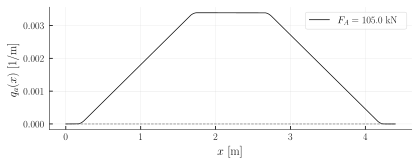

In [41]:
# | label: fig-q_x_mohr_sv14
# | fig-cap: Verlauf der Einwirkungen des Analogiesystems
plt.plot(
    x_array,
    q_x_mohr_array[-1],
    color="black",
    label=f"$F_A =$ {Laststufen[-1]/1000} kN",
)
plt.plot(x_array, 0 * x_array, color="gray", linestyle="dashed")

plt.xlabel(f"${sp.latex(x)}$ [m]")
plt.ylabel(f"${sp.latex(q_x_a)}$ [1/m]")
plt.legend()
plt.savefig("images/q_x_mohr_SV14.svg")

plt.show()

In der @fig-w_x_sv14 ist ersichtlich, dass für das analoge System Gelenke bei den Verformungsnullpunkten einzuführen sind, sowie Einspannungen beim Stabanfang und Ende. Grundsätzlich ist der Verformungsverlauf jedoch nicht vorgängig bekannt. Mit dieser Ausgangslage kann das analoge System mittels den Lagerungsbedingungen gemäss der @fig-randbedingungen_analogiesysteme definiert werden.

![Einwirkungen und Lagerung des Analogiesystems](../images/analogiesystem_14.svg){#fig-analogiesystem_sv14}


In [42]:
eq_V_x_mohr = sp.Eq(V_x_a, -sp.integrate(eq_q_x_mohr_num.rhs, x) + c_1)
eq_M_x_mohr = sp.Eq(M_x_a, sp.integrate(eq_V_x_mohr.rhs, x) + c_2)
randbedingung_1 = sp.Eq(eq_M_x_mohr.rhs.subs(x, a_1), 0).subs(params_plot)
randbedingung_2 = sp.Eq(eq_M_x_mohr.rhs.subs(x, a_1 + a_2 + a_3 + a_4), 0).subs(
    params_plot
)

c_a_solve = sp.solve([randbedingung_1, randbedingung_2], [c_1, c_2])
c_a_solve
eq_V_x_mohr_subs = eq_V_x_mohr.subs(c_a_solve)
eq_M_x_mohr_subs = eq_M_x_mohr.subs(c_a_solve)


V_x_mohr_lamb = sp.lambdify((F_A, x), eq_V_x_mohr_subs.rhs, "numpy")
M_x_mohr_lamb = sp.lambdify((F_A, x), eq_M_x_mohr_subs.rhs, "numpy")

In [43]:
V_x_mohr_array = []
M_x_mohr_array = []
for Last in Laststufen:
    V_x_mohr_array.append(V_x_mohr_lamb(Last, x_array))
    M_x_mohr_array.append(M_x_mohr_lamb(Last, x_array))

Der Querkraftverlauf für das analoge System ist in @fig-v_x_mohr_sv14 aufgezeigt. Die Querkraft ist einheitslos, da es sich um die Verdrehung handelt.

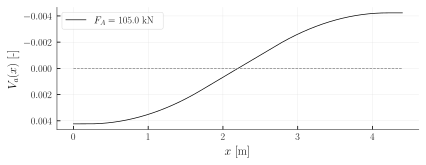

In [44]:
# | label: fig-v_x_mohr_sv14
# | fig-cap: Verlauf der Querkräfte des Analogiesystems

plt.plot(
    x_array,
    V_x_mohr_array[-1],
    color="black",
    label=f"$F_A =$ {Laststufen[-1]/1000} kN",
)
plt.plot(x_array, 0 * x_array, color="gray", linestyle="dashed")

plt.gca().invert_yaxis()
plt.xlabel(f"${sp.latex(x)}$ [m]")
plt.ylabel(f"${sp.latex(V_x_a)}$ [-]")
plt.legend()
plt.savefig("images/V_x_mohr_SV14.svg")

plt.show()

Den Biegemomentenverlauf für das analoge System zeigt die @fig-m_x_mohr_sv14. Der Momentenverlauf entspricht der Verformung und ist folglich in Millimeter dargestellt.

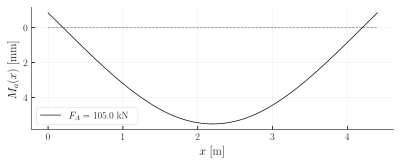

In [45]:
# | label: fig-m_x_mohr_sv14
# | fig-cap: Verlauf der Biegemomente des Analogiesystems

plt.plot(
    x_array,
    M_x_mohr_array[-1] * 1000,
    color="black",
    label=f"$F_A =$ {Laststufen[-1]/1000} kN",
)
plt.plot(x_array, 0 * x_array, color="gray", linestyle="dashed")

plt.gca().invert_yaxis()
plt.xlabel(f"${sp.latex(x)}$ [m]")
plt.ylabel(f"${sp.latex(M_x_a)}$ [mm]")
plt.legend()
plt.savefig("images/w_x_mohr_SV14.svg")

plt.show()

Erwartungsgemäss entspricht der Verlauf der Verformung in der @fig-m_x_mohr_sv14 dem Verlauf in der @fig-w_x_sv14.

## Abschätzung nach Norm

Nach der Bestimmung der elastischen Verformung kann die Verformung anhand des vollständig gerissenen Querschnitts gemäss der Norm @SIA2013a ermittelt werden. Die Kriecheinflüsse werden nicht berücksichtigt, da in den Versuchsdaten die Langzeiteinflüsse nicht abgebildet werden. Zur Reduktion des Rechenaufwands wird die Druckbewehrung ebenfalls vernachlässigt. Folglich ist die @eq-w_1_II_sia_simple anzuwenden. Dabei entspricht der geometrische Bewehrungsgehalt:

In [46]:
eq_rho = sp.Eq(rho, A_s / (b * d))
display(eq_rho)

        Aₛ
\rho = ───
       b⋅d

In [47]:
Eq_list.append(eq_rho)

Die notwendige Querschnittsfläche der Zugbewehrung wird folgend berechnet. Die Querschnittsfläche des hochfesten Stabs entspricht:

In [48]:
eq_A_s_1 = sp.Eq(A_s_1, sp.Mul(2, sp.pi * diam_s_1**2 / (4), evaluate=False))
eq_A_s_2 = eq_A_s_1.subs(A_s_1, A_s_2).subs(diam_s_1, diam_s_2)
eq_A_s = sp.Eq(A_s, A_s_1 + A_s_2)

eq_A_s_1_num = unit.convert_to(eq_A_s_1.subs(params), unit.mm)
eq_A_s_2_num = unit.convert_to(eq_A_s_2.subs(params), unit.mm)
eq_A_s_num = unit.convert_to(
    eq_A_s.subs(A_s_1, eq_A_s_1_num.rhs).subs(A_s_2, eq_A_s_2_num.rhs), unit.mm
)
display(eq_A_s_1,eq_A_s_1_num.evalf(3))


                      2
         π⋅\oslash_s,1 
Aₛ ₁ = 2⋅──────────────
               4       

                       2
Aₛ ₁ = 509.0⋅millimeter 

Die Querschnittsfläche des in der Mitte angeordneten Stabs entspricht:

In [49]:

display(eq_A_s_2, eq_A_s_2_num.evalf(3))


                    2
       π⋅\oslash_s,2 
Aₛ ₂ = ──────────────
             2       

                       2
Aₛ ₂ = 226.0⋅millimeter 

Die Querschnittsfläche der Stäbe im Zugbereich wird abschliessend bestimmt. Vereinfacht wird der Stab in der Mitte der Zugzone der Gesamtquerschnittsfläche hinzugezählt. 

In [50]:
display(eq_A_s, eq_A_s_num.evalf(4))

Aₛ = Aₛ ₁ + Aₛ ₂

                     2
Aₛ = 735.1⋅millimeter 

In [51]:
Eq_list.append(eq_A_s_num)
Eq_list.append(eq_A_s_1_num)
Eq_list.append(eq_A_s_2_num)

Die bereits bestimmte statische Höhe wird erneut aufgezeigt:

In [52]:
display(eq_d_mean, eq_d_mean_num.evalf(3))

    d₁   d₂
d = ── + ──
    2    2 

d = 408.0⋅millimeter

Damit lässt sich abschliessend die Verformung mittels der Abschätzformel für die maximale Laststufe bestimmen.

In [53]:
eq_w_1_gerissen_norm = sp.Eq(
    w_1_gerissen_norm,
    sp.Mul(0.75 / (10 * rho) ** sp.Rational(0.7), (h / d) ** 3 * w_1, evaluate=False),
)
eq_w_1_gerissen_norm_num = unit.convert_to(
    eq_subs(eq_w_1_gerissen_norm, *Eq_list)
    .subs(params)
    .subs(w_1, max(w_x_array_ungerissen[-1]) * unit.m),
    unit.mm,
)
w_1_gerissen_norm_lamb = sp.lambdify(
    (w_1),
    eq_w_1_gerissen_norm.rhs.subs(rho, eq_rho.rhs)
    .subs(d, eq_d_1_num.rhs.args[0])
    .subs(A_s, eq_A_s_num.rhs)
    .subs(params)
    .subs(unit.mm, 1),
    "numpy",
)
display(eq_w_1_gerissen_norm_num.evalf(3))

w_1_II,SIA = 26.7⋅millimeter

In [54]:
Eq_list.append(eq_w_1_gerissen_norm_num)

## Numerische Integration der Krümmung

Um sich von der Betrachtung einer konstanten Biegesteifigkeit zu lösen, hilft die Anwendung einer nicht-linearen Momenten-Krümmungs-Beziehung. Folgend wird ein Momenten-Krümmungs-Diagramm für den Querschnitt aus dem beschriebenen Versuch berechnet. Die vorhandene Querkraftbewehrung ist nicht dargestellt in @fig-qs_sv14.


![Querschnitt des Balkens dargestellt mit Zugbewehrung, ohne Schubbewehrung](../images/QS_Versuch14.svg){#fig-qs_sv14}


Zur Reduktion des Rechenaufwands wird der Querschnitt gemäss der @fig-qs_sv14_vereinfachung vereinfacht.

![Vereinfachung der Bewehrungsführung des Balkens](../images/QS_14.svg){#fig-qs_sv14_vereinfachung}

Sowie finden die Parameter in der @tbl-params_krummung_sv14 Einfluss in die Berechnungen. Die Indizes $1$ und $2$ der Parameter entsprechen der Beschriftung der Zugstäbe in der @fig-qs_sv14.

In [55]:
# | label: tbl-params_krummung_sv14
# | tbl-cap: Berechnungsparameter Momenten-Krümmungs-Beziehung


dict_to_table(params_krummung)

|  Parameter  | ​  |
|---|---|
| $E_{s} = \frac{205000.0 \text{N}}{\text{mm}^{2}}$ | $\oslash_{s,1} = 18.0 \text{mm}$ |
| $\oslash_{s,2} = 12.0 \text{mm}$ | $c_{nom} = 35.0 \text{mm}$ |
| $f_{cc} = \frac{46.7 \text{N}}{\text{mm}^{2}}$ | $f_{su,1} = \frac{800.0 \text{N}}{\text{mm}^{2}}$ |
| $f_{su,2} = \frac{657.0 \text{N}}{\text{mm}^{2}}$ | $f_{sy,1} = \frac{670.0 \text{N}}{\text{mm}^{2}}$ |
| $f_{sy,2} = \frac{550.0 \text{N}}{\text{mm}^{2}}$ | $\theta_{c3} = 30.0$ |
| $\varepsilon_{cu} = 0.003$ | $\varepsilon_{su} = 0.05$ |


Neben den Parametern wird das Stoffgesetz für den Betonstahl in @fig-stahlkennlinie_sv14 hinterlegt. Das bilineare, bzw. linear-elastisch linear-plastische Spannungs-Dehnungs-Diagramm für den Betonstahl hält den Rechenaufwand klein und liefert eine ausreichende Genauigkeit. Eine Berücksichtigung des verfestigenden Verhaltens ist essentiell, um die Verformungen nach dem Fliessen des Betonstahls näherungsweise zu bestimmen. Das Diagramm ist definiert bis zur Bruchdehnung $\varepsilon_{su}$ des Stahls. Das Verhalten gilt ebenso im negativen Spannungs-Dehnungs Bereich. Aufgezeigt sind beide Betonstähle, mit gleichen Elastizitätsmoduli im elastischen, sowie im verfestigenden Bereich.

In [56]:
eq_f_sy_1_lin = sp.Eq(f_sy, a + b * f_sy / E_s)
eq_f_su_1_lin = sp.Eq(f_su, a + b * epsilon_su)
eq_s1_lin = sp.Eq(sigma_epsilon_s, a + b * epsilon_s).subs(
    sp.solve([eq_f_sy_1_lin, eq_f_su_1_lin], [a, b])
)

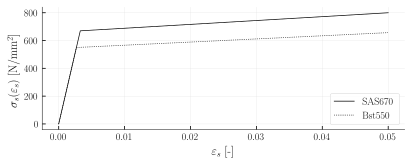

In [57]:
# | label: fig-stahlkennlinie_sv14
# | fig-cap: Linear-elastisches, ideal-plastisches Spannungs-Dehnungs-Diagramm des Betonstahls

# Funktionsverlauf für linear elastisch, linear plastisch
eq_sigma_epsilon_s = sp.Eq(
    sigma_epsilon_s,
    sp.Piecewise(
        (E_s * epsilon_s, (epsilon_s <= f_sy / E_s) & (epsilon_s >= 0)),
        (
            eq_s1_lin.rhs.subs(params_plot),
            (epsilon_s <= epsilon_su) & (epsilon_s >= f_sy / E_s),
        ),
    ),
)

# Bezogen auf die zwei Stahlsorten
eq_sigma_epsilon_s1 = eq_sigma_epsilon_s.subs(f_sy, f_sy_1).subs(f_su, f_su_1)
eq_sigma_epsilon_s2 = eq_sigma_epsilon_s.subs(f_sy, f_sy_2).subs(f_su, f_su_2)


eq_sigma_epsilon_s_num = eq_sigma_epsilon_s.subs(params_plot)


eq_sigma_epsilon_s_lamb = sp.lambdify(
    (f_sy, f_su, epsilon_s), eq_sigma_epsilon_s_num.rhs
)


# Dehnungswerte für den Plot
epsilon_s_array = np.linspace(0, np.float64(epsilon_su.subs(params_plot)), 2000)

# Für die Stäbe 1
eq_sigma_epsilon_array_1 = eq_sigma_epsilon_s_lamb(
    f_sy_1.subs(params_plot), f_su_1.subs(params_plot), epsilon_s_array
)

# Für den Stab 2
eq_sigma_epsilon_array_2 = eq_sigma_epsilon_s_lamb(
    f_sy_2.subs(params_plot), f_su_2.subs(params_plot), epsilon_s_array
)


plt.plot(
    epsilon_s_array, eq_sigma_epsilon_array_1 / 1000**2, color="black", label="SAS670"
)
plt.plot(
    epsilon_s_array,
    eq_sigma_epsilon_array_2 / 1000**2,
    color="black",
    linestyle="dotted",
    label="Bst550",
)

plt.xlabel(f"${sp.latex(epsilon_s)}$ [-]")
plt.ylabel(f"${sp.latex(sigma_epsilon_s)}$ [N/mm$ ^2$]")
plt.legend()
plt.savefig("images/spannung_dehnung_stahl_SV14.svg")

plt.show()

In [58]:
eq_sigma_epsilon_c = sp.Eq(
    sigma_epsilon_c,
    sp.Piecewise(
        (E_c * epsilon_c, (epsilon_c <= f_ct / E_c) & (epsilon_c > -f_c / E_c)),
        (-f_c, epsilon_c < -f_c / E_c),
    ),
)
eq_sigma_epsilon_c_num = eq_sigma_epsilon_c.subs(params_plot)

Die Betonkennlinie, die in @fig-betonkennlinie_sv14 dargestellt ist, zeigt ein linear-elastisches ideal-plastisches Verhalten. Im positiven Bereich lässt sich die Betonspannung bis zur Betonzugfestigkeit $f_{ct}$ erhöhen, im negativen Spannungsbereich beginnt ein Plastifizieren beim Erreichen der Betondruckfestigkeit $f_c$. Dies ist bis zur Bruchstauchung $\varepsilon_{cu}$ definiert.

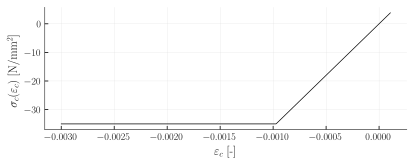

In [59]:
# | label: fig-betonkennlinie_sv14
# | fig-cap: Linear-elastisches, ideal-plastisches Spannungs-Dehnungs-Diagramm des Betons


eq_sigma_epsilon_c_lamb = sp.lambdify((epsilon_c), eq_sigma_epsilon_c_num.rhs)


epsilon_c_array = np.linspace(
    -np.float64(epsilon_cu.subs(params_plot)),
    np.float64(epsilon_cu.subs(params_plot)),
    2000,
)
eq_sigma_epsilon_c_array = eq_sigma_epsilon_c_lamb(epsilon_c_array)


plt.plot(epsilon_c_array, eq_sigma_epsilon_c_array / 1000**2, color="black")

plt.xlabel(f"${sp.latex(epsilon_c)}$ [-]")
plt.ylabel(f"${sp.latex(sigma_epsilon_c)}$ [N/mm$ ^2$]")
plt.savefig("images/spannung_dehnung_beton_SV14.svg")

plt.show()

### Querschnittsanalyse

Zur Bestimmung der nicht-linearen Momenten-Krümmungs-Beziehung wird eine Querschnittsanalyse durchgeführt. Dabei wird der Querschnitt vor dem Reissen (Zustand 1), nach dem Reissen (Zustand 2), beim Fliessen des Zugstabs 2 (Zustand 3), beim Fliessen der Zugstäbe 1 (Zustand 4) und beim Versagen (Zustand 5) untersucht. Durch die Wahl aussagekräftiger Zustände im Querschnitt lässt sich eine Momenten-Krümmungs-Beziehung mit überschaubarem Rechenaufwand ermitteln.

#### Schwerpunkt des Querschnitts

Die Bestimmung der Wertigkeit $n$ ermöglicht die Betrachtung des Querschnitts als homogenen Betonquerschnitt. Dies findet Einfluss bei der Schwerpunktsbestimmung, sowie bei der Bestimmung des Flächenträgheitmoments.

In [60]:
eq_n = sp.Eq(n, E_s / E_c)
eq_n_num = eq_n.subs(params)
display(eq_n, eq_n_num.evalf(3))

     Eₛ
n = ───
    E_c

n = 5.69

In [61]:
Eq_list.append(eq_n_num)

Mithilfe der Querschnittsfläche der Zugstäbe, sowie der Betonquerschnittsfläche lässt sich eine ideelle Querschnittsfläche ermitteln. Diese entspricht der Fläche eines reinen Betonquerschnitts. Die Querschnittsfläche der Zugstäbe ist die folgende:

In [62]:
display(eq_A_s, eq_A_s_num.evalf(4))

Aₛ = Aₛ ₁ + Aₛ ₂

                     2
Aₛ = 735.1⋅millimeter 

Dabei beträgt die Betonquerschnittsfläche:

In [63]:
eq_A_c = sp.Eq(A_c, b * h)
eq_A_c_num = unit.convert_to(eq_A_c.subs(params), unit.mm)
display(eq_A_c, eq_A_c_num)

A_c = b⋅h

                        2
A_c = 76500.0⋅millimeter 

In [64]:
Eq_list.append(eq_A_c_num)

Und die ideelle Querschnittsfläche resultiert zu:

In [65]:
eq_Ai = sp.Eq(A_i, A_c + A_s * (n - 1))
eq_Ai_num = unit.convert_to(eq_subs(eq_Ai, *Eq_list), unit.mm)
display(eq_Ai, eq_Ai_num.evalf(6))

Aᵢ = A_c + Aₛ⋅(n - 1)

                       2
Aᵢ = 79949.7⋅millimeter 

In [66]:
Eq_list.append(eq_Ai_num)

Der vertikale Abstand von der Oberkante zum Schwerpunkt, dargestellt ist dieser in der @fig-qs_sv14, beträgt:

In [67]:
eq_zeta_c = sp.Eq(
    zeta_c,
    sp.Mul(
        1 / A_i,
        A_c * h / 2 + (A_s_1 * (h - d_1) + A_s_2 * (h - d_2)) * (n - 1),
        evaluate=False,
    ),
)
eq_zeta_c_num = unit.convert_to(eq_subs(eq_zeta_c, *Eq_list).subs(params), unit.mm)
display(eq_zeta_c, eq_zeta_c_num.simplify().evalf(3))

      A_c⋅h                                            
      ───── + (n - 1)⋅(Aₛ ₁⋅(-d₁ + h) + Aₛ ₂⋅(-d₂ + h))
        2                                              
ζ_c = ─────────────────────────────────────────────────
                              Aᵢ                       

ζ_c = 217.0⋅millimeter

In [68]:
Eq_list.append(eq_zeta_c_num)

#### Flächenträgheitsmoment

Das Flächenträgheitsmoment wird ebenfalls am ideellen Querschnitt bestimmt. Die Eigenträgheitsmomente der Kreisquerschnitte der Stäbe sind nicht berücksichtigt, da deren Anteil überschaubar klein ist. Lediglich der Steiner-Anteil fliesst in die Berechnung ein:

In [69]:
eq_I_1 = sp.Eq(
    I_1,
    b * h**3 / 12
    + b * h * (h / 2 - zeta_c) ** 2
    + (
        A_s_1 * (c_nom + sp.Rational(0.5) * diam_s_1 - zeta_c) ** 2
        + A_s_2 * (c_nom + sp.Rational(0.5) * diam_s_2 - zeta_c) ** 2
    )
    * (n - 1),
)
eq_I_1_num = unit.convert_to(eq_subs(eq_I_1, *Eq_list).subs(params), unit.mm)
display(eq_I_1, eq_I_1_num.evalf(3))

          3                2           ⎛                               2      
       b⋅h        ⎛h      ⎞            ⎜     ⎛\oslash_s,1             ⎞       
I__I = ──── + b⋅h⋅⎜─ - ζ_c⎟  + (n - 1)⋅⎜Aₛ ₁⋅⎜─────────── + cₙₒₘ - ζ_c⎟  + Aₛ 
        12        ⎝2      ⎠            ⎝     ⎝     2                  ⎠       

                            2⎞
  ⎛\oslash_s,2             ⎞ ⎟
₂⋅⎜─────────── + cₙₒₘ - ζ_c⎟ ⎟
  ⎝     2                  ⎠ ⎠

                        4
I__I = 1.4e+9⋅millimeter 

In [70]:
Eq_list.append(eq_I_1_num)

#### Ungerissen - Zustand 1

Durch das durchwegs elastische Verhalten kann die Biegesteifigkeit anhand des Elastizitätmoduls des Betons und des Flächenträgheitmoments des ideellen Querschnitts bestimmt werden.

In [71]:
eq_EI_1 = sp.Eq(EI_I, I_1 * E_c)
eq_EI_I_num = eq_subs(eq_EI_1, *Eq_list).subs(params)

In [72]:
display(eq_EI_1, unit.convert_to(eq_EI_I_num.evalf(4), [unit.kilonewton, unit.meter]))

EI__I = E_c⋅I__I

                                 2
EI__I = 5.042e+4⋅kilonewton⋅meter 

In [73]:
Eq_list.append(eq_EI_I_num)

Das Rissmoment definiert den Endpunkt des Zustands I im Momenten-Krümmungs-Diagramm und wird folgend bestimmt. Dabei gilt die Modellierung gemäss @fig-qs2_sv14. Die Spannung in den Zugstäben wird vernachlässigt.

![Querschnittsanalyse vor dem Reissen des Betons](../images/QS_14_analyse_1.svg){#fig-qs2_sv14}


Die Betonspannung lässt sich anhand der über die Querschnittshöhe linear verlaufenden Spannung bestimmen. Dies ist folgend dargestellt:

In [74]:
eq_sigma_c_inf1 = sp.Eq(sigma_c_1, f_ct / zeta_c * (h - zeta_c))
eq_sigma_c_inf1_num = unit.convert_to(
    eq_subs(eq_sigma_c_inf1, *Eq_list).subs(params), unit.mm
)
display(eq_sigma_c_inf1, eq_sigma_c_inf1_num.evalf(3))

        f_ct⋅(h - ζ_c)
σ_c_1 = ──────────────
             ζ_c      

        4.17⋅newton
σ_c_1 = ───────────
                  2
        millimeter 

In [75]:
Eq_list.append(eq_sigma_c_inf1_num)

Zur Bestimmung des Rissmoments gilt es den Hebelarm der inneren Kräfte zu bestimmen, sowie die Betondruckkraft:

In [76]:
eq_z_r = sp.Eq(z_1, 2 * zeta_c / 2 + 2 * (h - zeta_c) / 3)
eq_z_r_num = unit.convert_to(eq_subs(eq_z_r, *Eq_list).subs(params), unit.mm)
display(eq_z_r, eq_z_r_num.evalf(3))

     2⋅h   ζ_c
z₁ = ─── + ───
      3     3 

z₁ = 372.0⋅millimeter

In [77]:
Eq_list.append(eq_z_r_num)

Die Betondruckkraft ist definiert nach:

In [78]:
eq_F_c_r = sp.Eq(F_c1, sigma_c_1 * b * (h - zeta_c) / 2)
eq_F_c_r_num = eq_subs(eq_F_c_r, *Eq_list).subs(params)

display(eq_F_c_r, unit.convert_to(eq_F_c_r_num.evalf(3), unit.kilonewton))

        b⋅σ_c_1⋅(h - ζ_c)
F_c,1 = ─────────────────
                2        

F_c,1 = 82.6⋅kilonewton

In [79]:
Eq_list.append(eq_F_c_r_num)

Und das Rissmoment resultiert schliesslich zu:

In [80]:
eq_M_r = sp.Eq(M_r, F_c1 * z_1)
eq_M_r_num = eq_subs(eq_M_r, *Eq_list)

display(eq_M_r, unit.convert_to(eq_M_r_num.evalf(4), [unit.kilonewton, unit.meter]))

Mᵣ = F_c,1⋅z₁

Mᵣ = 30.75⋅kilonewton⋅meter

In [81]:
Eq_list.append(eq_M_r_num)

Unter Berücksichtigung der Biegesteifigkeit lässt sich die Krümmung beim Reissen des Querschnitts bestimmen. Gezeigt in den folgenden Gleichungen:

In [82]:
eq_chi_r = sp.Eq(chi_r, M_r / (EI_I))
eq_chi_r_num = unit.convert_to(eq_subs(eq_chi_r, *Eq_list), unit.m)

Eq_list.append(eq_chi_r_num)
display(eq_chi_r, eq_chi_r_num.evalf(3))

          Mᵣ 
\chiᵣ = ─────
        EI__I

        0.00061
\chiᵣ = ───────
         meter 

#### Gerissen elastisch - Zustand 2

Mit dem Zustand 2 wird darauf abgezielt, den gerissenen Bereich im Momenten-Krümmungs-Diagramm darzustellen. Der Querschnitt nach dem Reissen ist in der @fig-qs3_sv14 dargestellt. Der Betonstahl hat die Fliessgrenze noch nicht erreicht. Der Beton hat die Druckfestigkeit ebenfalls nicht erreicht. Folgend werden analytische Beziehungen hergeleitet, welche den gesamten gerissenen Bereich beschreiben.


![Querschnittsanalyse nach dem Reissen des Betons](../images/QS_14_analyse_2.svg){#fig-qs3_sv14}

Dabei betragen die statischen Höhen der Zugstäbe:

In [83]:
display(eq_d_1_num, eq_d_2_num)

d₁ = 406.0⋅millimeter

d₂ = 409.0⋅millimeter

Mittels Gleichgewicht der Kräfte lässt sich die Betondruckzonenhöhe und folglich die gerissene Biegesteifigkeit herleiten. Die Betonstahlzugkräfte, für die Zugstäbe gesondert betrachtet, betragen:




In [84]:
eq_F_s21 = sp.Eq(F_s21, sigma_s_21 * A_s_1)
eq_F_s22 = eq_F_s21.subs(sigma_s_21, sigma_s_22).subs(F_s21, F_s22).subs(A_s_1, A_s_2)

display(eq_F_s21, eq_F_s22)

F_s2,1 = Aₛ ₁⋅σ_s_2,1

F_s2,2 = Aₛ ₂⋅σ_s_2,2

In [85]:
Eq_list.append(eq_F_s21)
Eq_list.append(eq_F_s22)

Die entsprechenden Betonstahlspannungen für linear-elastisches Verhalten folgen zu:

In [86]:
eq_sigma_s21 = sp.Eq(sigma_s_21, epsilon_s21 * E_s)
eq_sigma_s22 = eq_sigma_s21.subs(sigma_s_21, sigma_s_22).subs(epsilon_s21, epsilon_s22)

display(eq_sigma_s21, eq_sigma_s22)

σ_s_2,1 = Eₛ⋅varepsilon_s2,1

σ_s_2,2 = Eₛ⋅varepsilon_s2,2

In [87]:
Eq_list.append(eq_sigma_s21)
Eq_list.append(eq_sigma_s22)

Die Betondruckkraft anhand des dreieckigen Verlaufs in @fig-qs3_sv14 beträgt:


In [88]:
eq_F_c2 = sp.Eq(F_c2, sigma_c_2 * b * x_2 / 2)

eq_F_c2

        b⋅σ_c_2⋅x₂
F_c,2 = ──────────
            2     

In [89]:
Eq_list.append(eq_F_c2)

Die Betonspannung ebenfalls bestimmt durch ein linear-elastisches Verhalten ist definiert durch:

In [90]:
eq_sigma_c_2 = sp.Eq(sigma_c_2, epsilon_c2 * E_c)
eq_sigma_c_2

σ_c_2 = E_c⋅varepsilon_c2

In [91]:
Eq_list.append(eq_sigma_c_2)

Die Beton und Stahldehnung anhand der Stahldehnung des zweiten Stabs:

In [92]:
eq_epsilon_c2 = sp.Eq(epsilon_c2, epsilon_s22 / (d_2 - x_2) * x_2)

eq_epsilon_s21 = sp.Eq(epsilon_s21, epsilon_s22 / (d_2 - x_2) * (d_1 - x_2))

display(eq_epsilon_c2, eq_epsilon_s21)

                varepsilon_s2,2⋅x₂
varepsilon_c2 = ──────────────────
                     d₂ - x₂      

                  varepsilon_s2,2⋅(d₁ - x₂)
varepsilon_s2,1 = ─────────────────────────
                           d₂ - x₂         

In [93]:
Eq_list.append(eq_epsilon_c2)
Eq_list.append(eq_epsilon_s21)

Unter Bemühung des Gleichgewichts der horizontalen Kräfte lässt sich die folgende Beziehung ermitteln:

In [94]:
eq_ggw_1 = sp.Eq(F_c2, F_s21 + F_s22)
eq_ggw_1

F_c,2 = F_s2,1 + F_s2,2

In [95]:
Eq_list.append(eq_ggw_1)

Einsetzen der bestimmten Gleichungen in die Gleichgewichtsbeziehung und mit $n$ substituiert, folgt:

In [96]:
display(eq_n)

     Eₛ
n = ───
    E_c

In [97]:
eq_ggw_1_subs = (
    eq_ggw_1.subs(eq_F_c2.lhs, eq_F_c2.rhs)
    .subs(eq_F_s21.lhs, eq_F_s21.rhs)
    .subs(eq_F_s22.lhs, eq_F_s22.rhs)
    .subs(eq_sigma_c_2.lhs, eq_sigma_c_2.rhs)
    .subs(eq_sigma_s21.lhs, eq_sigma_s21.rhs)
    .subs(eq_sigma_s22.lhs, eq_sigma_s22.rhs)
    .subs(eq_epsilon_s21.lhs, eq_epsilon_s21.rhs)
    .subs(eq_epsilon_c2.lhs, eq_epsilon_c2.rhs)
    .subs(E_c, E_s / n)
    .simplify()
)

eq_ggw_1_subs

                       2                                                      
Eₛ⋅b⋅varepsilon_s2,2⋅x₂    Eₛ⋅varepsilon_s2,2⋅(Aₛ ₁⋅(d₁ - x₂) + Aₛ ₂⋅(d₂ - x₂)
──────────────────────── = ───────────────────────────────────────────────────
     2⋅n⋅(d₂ - x₂)                               d₂ - x₂                      

 
)
─
 

Mit deren Gleichung abschliessend die Betondruckzonenhöhe $x$ bestimmt werden kann.

In [98]:
eq_x_2 = sp.Eq(x_2, sp.solve(eq_ggw_1_subs, x_2)[1]).simplify()
eq_x_2_num = unit.convert_to(eq_subs(eq_x_2, *Eq_list).subs(params), unit.mm).simplify()
display(eq_x_2, eq_x_2_num.evalf(3))

                           ___________________________________________________
                          ╱   ⎛    2                                       2  
     -Aₛ ₁⋅n - Aₛ ₂⋅n + ╲╱  n⋅⎝Aₛ ₁ ⋅n + 2⋅Aₛ ₁⋅Aₛ ₂⋅n + 2⋅Aₛ ₁⋅b⋅d₁ + Aₛ ₂ ⋅n
x₂ = ─────────────────────────────────────────────────────────────────────────
                                                 b                            

________________
              ⎞ 
 + 2⋅Aₛ ₂⋅b⋅d₂⎠ 
────────────────
                

x₂ = 119.0⋅millimeter

In [99]:
Eq_list.append(eq_x_2)

Die hergeleiteten Beziehungen gelten für den gesamten gerissenen Bereich. Mit der freien Wahl eines Biegemoments kann die Betonstahldehnung und die erforderliche Krümmung bestimmt werden. Wird das in Zustand 1 ermittelte Rissmoment angesetzt, so lässt sich der Startpunkt des gerissenen Bereichs im Momenten-Krümmungs-Diagramm bestimmen.

In [100]:
eq_M_2 = sp.Eq(M_2, F_s22 * (d_2 - x_2 / 3) + F_s21 * (d_1 - x_2 / 3))
eq_M_2_M_r = sp.Eq(M_2, M_r)
eq_M_r_2 = eq_subs(
    eq_M_2, eq_F_s21, eq_F_s22, eq_sigma_s21, eq_sigma_s22, eq_epsilon_s21, eq_M_2_M_r
)

display(eq_M_2, eq_M_2_M_r, eq_M_r_2)

            ⎛     x₂⎞          ⎛     x₂⎞
M₂ = F_s2,1⋅⎜d₁ - ──⎟ + F_s2,2⋅⎜d₂ - ──⎟
            ⎝     3 ⎠          ⎝     3 ⎠

M₂ = Mᵣ

                                       ⎛     x₂⎞                              
     Aₛ ₁⋅Eₛ⋅varepsilon_s2,2⋅(d₁ - x₂)⋅⎜d₁ - ──⎟                              
                                       ⎝     3 ⎠                           ⎛  
Mᵣ = ─────────────────────────────────────────── + Aₛ ₂⋅Eₛ⋅varepsilon_s2,2⋅⎜d₂
                       d₂ - x₂                                             ⎝  

      
      
   x₂⎞
 - ──⎟
   3 ⎠

In [101]:
Eq_list.append(eq_M_2)
Eq_list.append(eq_M_2_M_r)

Daraus resultiert die Betonstahldehnung und die entsprechende Betonstahlspannung:

In [102]:
eq_epsilon_s22 = sp.Eq(epsilon_s22, sp.solve(eq_M_r_2, epsilon_s22)[0])

eq_epsilon_s22_num = (
    eq_subs(
        eq_epsilon_s22, eq_M_r_num, eq_x_2, eq_A_s_1, eq_d_1, eq_d_2, eq_A_s_2, eq_n
    )
    .subs(params)
    .simplify()
)
Eq_list.append(eq_epsilon_s22_num)

eq_sigma_s_22_num = eq_subs(eq_sigma_s22, eq_epsilon_s22_num).subs(params)



display(eq_epsilon_s22_num.evalf(3), eq_sigma_s_22_num.evalf(3))

varepsilon_s2,2 = 0.00056

          115.0⋅newton
σ_s_2,2 = ────────────
                    2 
          millimeter  

Die Krümmung kann anhand des Dehnungsverlaufs in @fig-qs3_sv14 bestimmt werden:

In [103]:
eq_chi_II = sp.Eq(chi_II, epsilon_s22 / (d_2 - x_2))
eq_chi_II_num = unit.convert_to(
    eq_subs(eq_chi_II, eq_x_2_num, eq_d_2_num, eq_epsilon_s22_num).simplify(), unit.m
)
Eq_list.append(eq_chi_II)

display(eq_chi_II, eq_chi_II_num.evalf(3))

             varepsilon_s2,2
\chi__{II} = ───────────────
                 d₂ - x₂    

             0.00193
\chi__{II} = ───────
              meter 

Abschliessend folgt die gerissene Biegesteifigkeit zu:

In [104]:
eq_EI_II = sp.Eq(EI_II, M_2 / chi_II)
eq_EI_II_num = eq_subs(eq_EI_II, *Eq_list).subs(params).simplify()
Eq_list.append(eq_EI_II_num)

In [105]:
display(eq_EI_II, unit.convert_to(eq_EI_II_num.evalf(6), [unit.kilonewton, unit.meter]))

               M₂    
EI__{II} = ──────────
           \chi__{II}

                                   2
EI__{II} = 15932.3⋅kilonewton⋅meter 

#### Fliessen der Bewehrung 2 - Zustand 3

Der Zustand 3 entspricht dem Zustand 2. Einzig die Stahlspannung im Stab 2 erreicht die Fliessspannung. Dargestellt ist dies in der @fig-qs4_sv14.

![Querschnittsanalyse mit erreichter Fliessspannung im Stab 2](../images/QS_14_analyse_3.svg){#fig-qs4_sv14}

Die Dehnungen in den Stäben folgen zu:

In [106]:
eq_epsilon_s32 = sp.Eq(epsilon_s32, f_sy_2 / E_s)
eq_epsilon_s32_num = eq_epsilon_s32.subs(params)
display(eq_epsilon_s32, eq_epsilon_s32_num.evalf(3))

                  f_sy,2
varepsilon_s3,2 = ──────
                    Eₛ  

varepsilon_s3,2 = 0.00268

Die Betondruckzonenhöhe bleibt unverändert, sofern der Beton im elastischen Zustand verbleibt.

In [107]:
eq_x_3 = eq_x_2.subs(x_2, x_3)
eq_x_3_num = eq_x_2_num.subs(x_2, x_3)
display(eq_x_3_num.evalf(3))

x₃ = 119.0⋅millimeter

Die Betonstahldehnung anhand des linearen Dehnungsverlaufs entspricht:

In [108]:
eq_epsilon_s31 = (
    eq_epsilon_s21.subs(epsilon_s22, epsilon_s32)
    .subs(epsilon_s21, epsilon_s31)
    .subs(x_2, x_3)
)
eq_epsilon_s31_num = eq_subs(
    eq_epsilon_s31, eq_d_2_num, eq_d_1_num, eq_epsilon_s32_num, eq_x_3_num
)
display(eq_epsilon_s31, eq_epsilon_s31_num.evalf(3))

                  varepsilon_s3,2⋅(d₁ - x₃)
varepsilon_s3,1 = ─────────────────────────
                           d₂ - x₃         

varepsilon_s3,1 = 0.00266

Die Betonstauchung folgt zu:

In [109]:
eq_epsilon_c3 = sp.Eq(epsilon_c3, epsilon_s31 / (d_1 - x_3) * x_3)
eq_epsilon_c3_num = eq_subs(eq_epsilon_c3, eq_d_1_num, eq_epsilon_s31_num, eq_x_3_num)
display(eq_epsilon_c3, eq_epsilon_c3_num.evalf(3))

                varepsilon_s3,1⋅x₃
varepsilon_c3 = ──────────────────
                     d₁ - x₃      

varepsilon_c3 = 0.0011

Die maximale elastische Dehnung ist folgend gezeigt, welche mit $\varepsilon_{c3}$ zu vergleichen ist:

In [110]:
sp.Eq(f_c / E_c, (f_c / E_c).subs(params).evalf(3))

f_c           
─── = 0.000972
E_c           

Es zeigt sich, dass der Beton im äussersten Bereich bereits plastifiziert. Die Abweichung ist jedoch gering. Um den Rechenaufwand gering zu halten, wird diese Tatsache nicht berücksichtigt, bzw. mit einem elastischen Betonverhalten weiterverfahren. Folgend ist die Höhe des plastifizierten Bereichs berechnet, gemessen von der äussersten Faser. Diese Grösse dient dazu den Fehler der Vereinfachung abzuschätzen. Der geringe Abstand lässt die Annahme zu.

In [111]:
eq_abstand_plast_3 = sp.Eq(
    a, (x_3 - (sp.solve(sp.Eq(f_c / E_c, epsilon_c3 / x_3 * y), y)[0]))
)
eq_abstand_plast_3_num = (
    eq_abstand_plast_3.subs(x_3, eq_x_3_num.rhs)
    .subs(epsilon_c3, eq_epsilon_c3_num.rhs)
    .subs(params)
)

display(eq_abstand_plast_3, eq_abstand_plast_3_num.evalf(3))

               f_c⋅x₃     
a = x₃ - ─────────────────
         E_c⋅varepsilon_c3

a = 14.0⋅millimeter

Daraus lässt sich das Fliessmoment bestimmen, welches den Endpunkt im Momenten-Krümmungs-Diagramm für den gerissenen Zustand definiert:

In [112]:
eq_M_y2 = sp.Eq(
    M_y_2,
    (
        A_s_1 * E_s * epsilon_s31 * (d_1 - x_3 / 3)
        + A_s_2 * E_s * epsilon_s32 * (d_2 - x_3 / 3)
    ),
)
eq_M_y2_num = (
    eq_subs(
        eq_M_y2,
        eq_epsilon_s31_num,
        eq_epsilon_s32_num,
        eq_A_s_1_num,
        eq_A_s_2_num,
        eq_d_1_num,
        eq_d_2_num,
        eq_x_3_num,
    )
    .subs(params)
    .simplify()
)
display(eq_M_y2, unit.convert_to(eq_M_y2_num.evalf(4), [unit.kilonewton, unit.meter]))

                                ⎛     x₃⎞                           ⎛     x₃⎞
M_y_2 = Aₛ ₁⋅Eₛ⋅varepsilon_s3,1⋅⎜d₁ - ──⎟ + Aₛ ₂⋅Eₛ⋅varepsilon_s3,2⋅⎜d₂ - ──⎟
                                ⎝     3 ⎠                           ⎝     3 ⎠

M_y_2 = 147.4⋅kilonewton⋅meter

Abschliessend lässt sich die Krümmung für den Endpunkt des Zustands 3 bestimmen:

In [113]:
eq_chi_y2 = sp.Eq(chi_y2, epsilon_s31 / (d_1 - x_3))

In [114]:
eq_chi_y2_num = (
    eq_subs(eq_chi_y2, eq_epsilon_s31_num, eq_d_1_num, eq_x_3_num)
    .subs(params)
    .simplify()
)
Eq_list.append(eq_chi_y2_num)
display(eq_chi_y2, unit.convert_to(eq_chi_y2_num.evalf(3), unit.meter))

          varepsilon_s3,1
\chi_y2 = ───────────────
              d₁ - x₃    

          0.00925
\chi_y2 = ───────
           meter 

#### Fliessen der Bewehrung 1 - Zustand 4

Der Zustand 4 entspricht dem Zustand 3. Als einzige Abweichung erreicht die Stahlspannung im Stab 1 nun ebenfalls die Fliessspannung.

![Querschnittsanalyse mit erreichter Fliessspannung im Stab 1](../images/QS_14_analyse_4.svg){#fig-qs5_sv14}

Die Dehnungen in den Stäben, vereinfacht wird die Dehnung in beiden Stäben gleichgesetzt, folgen zu:

In [115]:
eq_epsilon_s41 = sp.Eq(epsilon_s41, f_sy_1 / E_s)
eq_epsilon_s41_num = eq_epsilon_s41.subs(params)
display(eq_epsilon_s41, eq_epsilon_s41_num.evalf(3))


eq_epsilon_s42 = sp.Eq(epsilon_s42, epsilon_s41)
eq_epsilon_s42_num = eq_subs(eq_epsilon_s42, eq_epsilon_s41_num)
display(eq_epsilon_s42)

                  f_sy,1
varepsilon_s4,1 = ──────
                    Eₛ  

varepsilon_s4,1 = 0.00327

varepsilon_s4,2 = varepsilon_s4,1

Es wird weiterhin von einer dreiecksförmigen Betonspannungsverteilung ausgegangen.

In [116]:
eq_x_4 = eq_x_2.subs(x_2, x_4)
eq_x_4_num = eq_x_2_num.subs(x_2, x_4)
display(eq_x_4_num.evalf(3))

x₄ = 119.0⋅millimeter

Die Betonstauchung folgt zu:

In [117]:
eq_epsilon_c4 = sp.Eq(epsilon_c4, epsilon_s41 / (d_1 - x_4) * x_4)
eq_epsilon_c4_num = eq_subs(eq_epsilon_c4, eq_d_1_num, eq_epsilon_s41_num, eq_x_4_num)
display(eq_epsilon_c4, eq_epsilon_c4_num.evalf(3))

                varepsilon_s4,1⋅x₄
varepsilon_c4 = ──────────────────
                     d₁ - x₄      

varepsilon_c4 = 0.00136

Auch hier gilt, dass der Beton eigentlich bereits plastifiziert. Der Abstand des plastischen Bereichs von der äussersten Faser ist folgend erneut berechnet und zeigt einen grösseren Bereich. Dennoch wird mit einem dreieckigen Betonspannungsverlauf weiterverfahren.

In [118]:
eq_abstand_plast_4 = eq_abstand_plast_3.subs(x_3, x_4).subs(epsilon_c3, epsilon_c4)
eq_abstand_plast_4_num = (
    eq_abstand_plast_4.subs(x_4, eq_x_4_num.rhs)
    .subs(epsilon_c4, eq_epsilon_c4_num.rhs)
    .subs(params)
)

display(eq_abstand_plast_4, eq_abstand_plast_4_num.evalf(3))

               f_c⋅x₄     
a = x₄ - ─────────────────
         E_c⋅varepsilon_c4

a = 33.7⋅millimeter

Die Spannungen anhand des bilinearen Spannungs-Dehnungsverlauf folgen zu:

In [119]:
eq_sigma_s41 = sp.Eq(
    sigma_s_41,
    unit.convert_to(
        eq_sigma_epsilon_s1.subs(epsilon_s, eq_epsilon_s41_num.rhs.evalf(3))
        .subs(params_plot)
        .rhs
        * unit.N
        / unit.m**2,
        unit.N / unit.mm**2,
    ),
)
eq_sigma_s42 = sp.Eq(
    sigma_s_42,
    unit.convert_to(
        eq_sigma_epsilon_s2.subs(epsilon_s, eq_epsilon_s42_num.rhs.evalf(3))
        .subs(params_plot)
        .rhs
        * unit.N
        / unit.m**2,
        unit.N / unit.mm**2,
    ),
)

display(eq_sigma_s41.evalf(3), eq_sigma_s42.evalf(3))

          670.0⋅newton
σ_s_4,1 = ────────────
                    2 
          millimeter  

          551.0⋅newton
σ_s_4,2 = ────────────
                    2 
          millimeter  

Es zeigt sich, dass die Spannung im Stab 2 in etwa der Fliessspannung entspricht. Daraus lässt sich das Fliessmoment bestimmen, welches den Endpunkt im Momenten-Krümmungs-Diagramm für den gerissenen Zustand definiert:

In [120]:
eq_M_y1 = sp.Eq(
    M_y_1,
    (A_s_1 * E_s * epsilon_s41 * (d_1 - x_4 / 3) + A_s_2 * f_sy_2 * (d_2 - x_4 / 3)),
)
eq_M_y1_num = (
    eq_subs(
        eq_M_y1,
        eq_epsilon_s41_num,
        eq_epsilon_s42_num,
        eq_A_s_1_num,
        eq_A_s_2_num,
        eq_d_1_num,
        eq_d_2_num,
        eq_x_4_num,
    )
    .subs(params)
    .simplify()
)
display(eq_M_y1, unit.convert_to(eq_M_y1_num.evalf(4), [unit.kilonewton, unit.meter]))

                                ⎛     x₄⎞               ⎛     x₄⎞
M_y_1 = Aₛ ₁⋅Eₛ⋅varepsilon_s4,1⋅⎜d₁ - ──⎟ + Aₛ ₂⋅f_sy,2⋅⎜d₂ - ──⎟
                                ⎝     3 ⎠               ⎝     3 ⎠

M_y_1 = 170.9⋅kilonewton⋅meter

Abschliessend lässt sich die Krümmung für den Endpunkt des Zustands 4 bestimmen:

In [121]:
eq_chi_y1 = sp.Eq(chi_y1, epsilon_s41 / (d_1 - x_4))

In [122]:
eq_chi_y1_num = (
    eq_subs(eq_chi_y1, eq_epsilon_s41_num, eq_d_1_num, eq_x_4_num)
    .subs(params)
    .simplify()
)
Eq_list.append(eq_chi_y1_num)
display(eq_chi_y1, unit.convert_to(eq_chi_y1_num.evalf(3), unit.meter))

          varepsilon_s4,1
\chi_y1 = ───────────────
              d₁ - x₄    

          0.0114
\chi_y1 = ──────
          meter 

#### Biegewiderstand - Zustand 5

Der Biegewiderstand kann durch die Plastifizierung der Betondruckzone bestimmt werden. Vereinfacht werden den Zugstäben die entsprechende statische Zugfestigkeit hinterlegt, um das verfestigende Verhalten annähernd abzubilden.


![Querschnittsanalyse mit erreichter Zugfestigkeit im Stab und plastifizierter Betondruckzone](../images/QS_14_analyse_5.svg){#fig-qs6_sv14}

Es wird die Betonbruchstauchung vorausgesetzt:

In [123]:
eq_epsilon_c5 = sp.Eq(epsilon_c5, epsilon_cu)

eq_epsilon_c5

varepsilon_c5 = varepsilon_cu

Der Druckspannungsverlauf wird als rechteckigen Spannungsblock modelliert. Dazu wird die Druckzonenhöhe um den Faktor 0.85 reduziert. Das Gleichgewicht der Kräfte führt zu:

In [124]:
eq_ggw_R = sp.Eq(
    A_s_1 * f_su_1 + A_s_2 * f_su_2, sp.Mul(0.85, x_5 * b * f_c, evaluate=False)
)

display(eq_ggw_R)

Aₛ ₁⋅f_su,1 + Aₛ ₂⋅f_su,2 = 0.85⋅b⋅f_c⋅x₅

Aus dem Gleichgewicht der horizontalen Kräfte folgt die Druckzonenhöhe zu:

In [125]:
eq_x_5 = sp.Eq(x_5, sp.solve(eq_ggw_R, x_5)[0])
eq_x_5_num = unit.convert_to(eq_subs(eq_x_5, *Eq_list).subs(params), unit.mm)

display(eq_x_5_num.evalf(3))

x₅ = 110.0⋅millimeter

Damit lässt sich der Hebelarm der inneren Kräfte bestimmen:

In [126]:
eq_z_5 = sp.Eq(z_5, d_1 - 0.425 * x_5)
eq_z_5_num = eq_subs(eq_z_5, eq_d_1_num, eq_x_5_num)
display(eq_z_5, eq_z_5_num.evalf(3))

z₅ = d₁ - 0.425⋅x₅

z₅ = 359.0⋅millimeter

In [127]:
Eq_list.append(eq_x_5_num)

Welche den Biegewiderstand ermitteln lässt:

In [128]:
eq_M_R = sp.Eq(
    M_R,
    A_s_1 * f_su_1 * (d_1 - 0.85 * x_5 / 2) + A_s_2 * f_su_2 * (d_2 - 0.85 * x_5 / 2),
)
eq_M_R_num = unit.convert_to(eq_subs(eq_M_R, *Eq_list).subs(params), unit.m)

Eq_list.append(eq_M_R_num)
display(eq_M_R, unit.convert_to(eq_M_R_num.evalf(4), unit.kilonewton))

M_R = Aₛ ₁⋅f_su,1⋅(d₁ - 0.425⋅x₅) + Aₛ ₂⋅f_su,2⋅(d₂ - 0.425⋅x₅)

M_R = 200.1⋅kilonewton⋅meter

Die Krümmung lässt sich anhand der Betonstauchung ermitteln:

In [129]:
eq_chi_u = sp.Eq(chi_u, epsilon_cu / x_5)
eq_chi_u_num = eq_subs(eq_chi_u, *Eq_list).subs(params)

Eq_list.append(eq_chi_u_num)

display(eq_chi_u, unit.convert_to(eq_chi_u_num.evalf(3), unit.meter))

        varepsilon_cu
\chiᵤ = ─────────────
              x₅     

        0.0273
\chiᵤ = ──────
        meter 

Sowie wird kontrolliert, dass die Betonstahldehnung die Bruchdehnung nicht überschreiten. Die Betonstahldehnung wird für beide Stäbe gleichgesetzt.

In [130]:
eq_epsilon_s51 = sp.Eq(epsilon_s51, epsilon_c5 / x_5 * (d_1 - x_5))
eq_epsilon_s51_num = eq_subs(
    eq_epsilon_s51, eq_d_1_num, eq_epsilon_c5, eq_x_5_num
).subs(params)
eq_epsilon_s52 = sp.Eq(epsilon_s52, epsilon_s51)
eq_epsilon_s52_num = eq_subs(eq_epsilon_s52, eq_epsilon_s51_num)


display(eq_epsilon_s51, eq_epsilon_s52, eq_epsilon_s51_num.evalf(3))

                  varepsilon_c5⋅(d₁ - x₅)
varepsilon_s5,1 = ───────────────────────
                             x₅          

varepsilon_s5,2 = varepsilon_s5,1

varepsilon_s5,1 = 0.00809

In [131]:
sp.Eq(epsilon_su, params[epsilon_su])

varepsilonₛᵤ = 0.05

Die Bruchdehnung des Stahls wird nicht erreicht. Der Querschnitt versagt im Druckbereich. Die Annahme, dem Betonstahl die statische Zugfestigkeit zugrunde zu legen ist nicht gerechtfertigt. Dies wird vernachlässigt zur Reduktion des Rechenaufwands. Abschliessend lässt sich die Biegesteifigkeit für den verfestigenden Bereich bestimmen:

In [132]:
eq_EI_III = sp.Eq(EI_III, (M_R) / (chi_u))
eq_EI_III_num = eq_subs(eq_EI_III, *Eq_list).simplify()
display(
    eq_EI_III, unit.convert_to(eq_EI_III_num.evalf(3), [unit.kilonewton, unit.meter])
)

             M_R 
EI__{III} = ─────
            \chiᵤ

                                    2
EI__{III} = 7.33e+3⋅kilonewton⋅meter 

In [133]:
M_to_chi_array = np.array(
    [
        eq_M_r_num.evalf(8),
        eq_M_r_num.evalf(8),
        eq_M_r_num.evalf(8),
        eq_M_y2_num.evalf(8),
        eq_M_y1_num.evalf(8),
        eq_M_R_num.evalf(8),
    ]
)

chi_to_M_array = np.array(
    [
        eq_chi_r_num.evalf(8),
        eq_chi_r_num.evalf(8),
        eq_chi_II_num.evalf(8),
        eq_chi_y2_num.evalf(8),
        eq_chi_y1_num.evalf(8),
        eq_chi_u_num.evalf(8),
    ]
)

In [134]:
for i, M_to_chi in enumerate(M_to_chi_array):
    M_to_chi_array[i] = np.float64(
        unit.convert_to(M_to_chi.rhs, unit.meter * unit.newton)
        / unit.meter
        / unit.newton
    )

M_to_chi_array[0] = 0
M_to_chi_array = M_to_chi_array.astype(float)

for i, chi_to_M in enumerate(chi_to_M_array):
    chi_to_M_array[i] = np.float64(unit.convert_to(chi_to_M.rhs, 1 / unit.m) * unit.m)

chi_to_M_array[0] = 0
chi_to_M_array = chi_to_M_array.astype(float)


def chi_from_M_interpolate(M_x):
    chi_interp = np.interp(M_x, M_to_chi_array, chi_to_M_array)
    return chi_interp

In [135]:
chi_on_x = []

for M_x in M_x_array[-1]:
    chi_on_x.append(chi_from_M_interpolate(M_x))

#### Momenten-Krümmungs-Diagramm

Die definierten Krümmungen mit den entsprechenden Biegemomenten aus der Querschnittsanalyse sind in @fig-mchi_diagramm_sv14 aufgezeigt. 

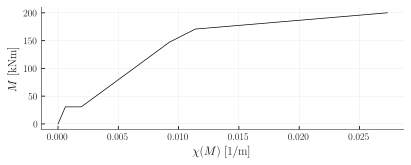

In [136]:
# | label: fig-mchi_diagramm_sv14
# | fig-cap: Momenten-Krümmungs-Diagramm, definiert durch die Querschnittsanalyse 

# M_R_num = np.float64(eq_M_R_num.rhs.evalf(4) /unit.m/unit.N)
# chi_M_lambda = sp.lambdify((M, EI_I, EI_II, EI_III, M_r, M_y, M_R), eq_chi_M.rhs)
# M_to_chi_array = np.linspace(0,M_R_num * 2, 500)
# chi_M_to_chi_array = chi_M_lambda(M_to_chi_array, *M_chi_params)
plt.plot(chi_to_M_array, M_to_chi_array / 1000, color="black")

# Anmerkungen hinzufügen


plt.xlabel(f"${sp.latex(chi_M)}$ [1/m]")
plt.ylabel(f"${sp.latex(M)}$ [kNm]")


plt.savefig("images/momenten_krummung_SV14.svg")


plt.show()

Die erste Steigung im Diagramm beschreibt den ungerissenen Zustand. Dieser hat die Neigung von $EI^I$. Darauf folgt eine schlagartige Erhöhung der Krümmung ohne Steigerung des Moments. Dies entspricht dem Übergang vom ungerissenen zum gerissenen Zustand. Dabei steigt der Verlauf mit der Neigung $EI^{II}$ bis zum Fliessen der Bewehrung 2. Der folgende Knick resultiert aus den unterschiedlichen Fliesspunkten der Zugbewehrung. Nach dem Erreichen des Fliessens in beiden Stäben folgt ein verfestigendes Verhalten des Betonstahls und ein Plastifizieren der Betondruckzone bis zum Erreichen des Biegewiderstands.

#### Zustandslinien der Krümmung

Mittels der nicht-linearen Momenten-Krümmungs-Beziehung lässt sich der Krümmungsverlauf bestimmen.
Der Biegemomentenverlauf $M(x)$, als Eingabe in die Funktion der Krümmung $\chi(M)$, führt zu den Zustandslinien der Krümmung in @fig-chi_x_diagramm_sv14. Dargestellt ist der Krümmungsverlauf exemplarisch für die Zustandslinien der Biegemomente aus der @fig-m_x_sv14.


In [137]:
chi_M_versuch_2 = []
for M_x in M_x_array:
    chi_M_versuch_2.append(chi_from_M_interpolate(M_x))

chi_M_versatz_versuch_2 = []
for M_x in M_x_array_versatz:
    chi_M_versatz_versuch_2.append(chi_from_M_interpolate(M_x))

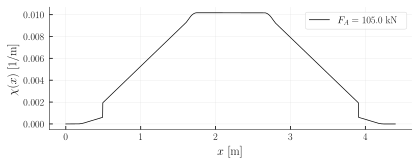

In [138]:
# | label: fig-chi_x_diagramm_sv14
# | fig-cap: Krümmungsverlauf entlang der Stabachse

plt.plot(
    x_array,
    chi_M_versuch_2[-1],
    color="black",
    label=f"$F_A =$ {Laststufen[-1]/1000} kN",
)
# plt.plot(x_array, chi_M_versatz_versuch_2[-1], color='darkgreen', label='Versatzmass')


plt.xlabel(f"${sp.latex(x)}$ [m]")
plt.ylabel(f"$\\chi(x)$ [1/m]")
plt.legend()
plt.savefig("images/krummungsverlauf_SV14.svg")

plt.show()

In der Feldmitte zeigt sich allmählich ein Fliessen des Stabs 2. Vereinfachend lässt sich festhalten, dass die Bewehrung nicht ins Fliessen kommt.

#### Punktuelle Bestimmung der Verformung


Unter Anwendung der Arbeitsgleichung kann die Verformung nach @eq-arbeitsgleichung bestimmt werden. Die virtuelle Kraft $\bar{F} = 1$ wird in der Feldmitte angesetzt und resultiert zum virtuellen Biegemomentenverlauf, dargestellt in der @fig-m_x_diagramm_virtuell_sv14.

In [139]:
def M_fiktiv(x_array):
    m_fiktiv_array = np.array([])

    for x in x_array:
        if x <= 0.2:
            m_fiktiv_array = np.append(m_fiktiv_array, 0)

        if x >= 0.2 and x <= 2.2:
            m_fiktiv_array = np.append(m_fiktiv_array, x / 2 - 0.1)

        if x >= 2.2 and x <= 4.2:
            m_fiktiv_array = np.append(m_fiktiv_array, -x / 2 + 2.1)

        if x >= 4.2 and x <= 4.4:
            m_fiktiv_array = np.append(m_fiktiv_array, 0)

    return m_fiktiv_array


M_x_array_fiktiv = M_fiktiv(x_array)

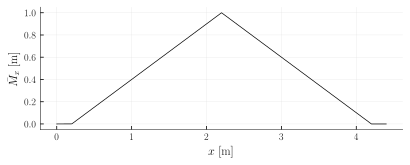

In [140]:
# | label: fig-m_x_diagramm_virtuell_sv14
# | fig-cap: Biegemomentenverlauf für den virtuellen Kräftezustand

plt.plot(x_array, M_x_array_fiktiv, color="black")
# plt.plot(x_array, M_x_array_fiktiv, color='darkgreen', label='Versatzmass')

plt.xlabel(f"${sp.latex(x)}$ [m]")
plt.ylabel("$\\bar{M}_x$ [m]")
plt.savefig("images/M_virtuell_SV14.svg")

plt.show()

In [141]:
w_1_m_chi = []

for i in range(0, len(M_x_array_versatz)):
    w_1_m_chi.append(np.trapz(M_x_array_fiktiv * chi_M_versuch_2[i], x_array))


w_1_m_chi_versatz = []

for i in range(0, len(M_x_array_versatz)):
    w_1_m_chi_versatz.append(
        np.trapz(M_x_array_fiktiv * chi_M_versatz_versuch_2[i], x_array)
    )

Mit dem bestimmen Krümmungsverlauf lässt sich die Deformation an der Stelle $w_1$ für die Maximallast exemplarisch bestimmen:

In [142]:
eq_w_1_m_chi = unit.convert_to(sp.Eq(w_1, w_1_m_chi[-1] * unit.m), unit.mm)
eq_w_1_m_chi.evalf(3)

w₁ = 16.3⋅millimeter

### Zugversteifung

In diesem Abschnitt wird die Modellbildung nach Marti, gemäss @sec-zuggurtmodell, angewendet. Dazu wird die Krümmungsdifferenz, der Rissabstand und die Rissweiten bestimmt. Im Versuchsbericht @Tue2019 sind keine Rissweiten aufgeführt, welche mit den Berechnungen verglichen werden können. Die Krümmungsdifferenez nach Marti mit der mittleren statischen Höhe in Abhängigkeit des $\lambda$-Parameters beträgt:

In [143]:
eq_d_mean_num

d = 407.5⋅millimeter

In [144]:
#Formeln

eq_delta_chi_gamma = sp.Eq(delta_chi, sp.Mul(lamb / 2, f_ct * (1-rho_eff)/(rho_eff * E_s*(d-x_2)), evaluate=False))
eq_rho_eff = sp.Eq(rho_eff, (M_r*(d-x_2) * E_s / (f_ct * EI_II)+1-n)**-1)
eq_srm = sp.Eq(s_rm, lamb * (diam_s_1+ diam_s_2)/2*(1-rho_eff)/(4*rho_eff))
eq_sigma_sr0 = sp.Eq(sigma_sr0, F_s22 / A_s_2)
eq_w_r = sp.Eq(w_r, s_rm * (2*sigma_sr - lamb * sigma_sr0) / (2*E_s))

# Numerische Werte
eq_w_r_lamb = sp.lambdify((sigma_sr, sigma_sr0,s_rm, lamb, E_s), eq_w_r.rhs)
eq_delta_chi_gamma_num = unit.convert_to(eq_subs(eq_delta_chi_gamma, eq_rho_eff, eq_M_r_num, eq_EI_II_num, eq_n_num, eq_x_2_num, eq_d_mean_num).subs(params), unit.m)
eq_rho_eff_num = eq_subs(eq_rho_eff, *Eq_list).subs(params)
eq_srm_num = eq_subs(eq_srm, eq_rho_eff_num).subs(params)



display(eq_delta_chi_gamma,eq_delta_chi_gamma_num.evalf(3))


Eq_list.extend([eq_delta_chi_gamma, eq_rho_eff, eq_srm,eq_sigma_sr0, eq_w_r])

                λ  f_ct⋅(1 - ρ_eff)
\Delta\chi(λ) = ─⋅─────────────────
                2 Eₛ⋅ρ_eff⋅(d - x₂)

                0.000779⋅λ
\Delta\chi(λ) = ──────────
                  meter   

Der mechanische Bewehrungsgehalt folgt zu:

In [145]:
display(eq_rho_eff, eq_rho_eff_num.simplify().evalf(3))

                   1           
ρ_eff = ───────────────────────
                 Eₛ⋅Mᵣ⋅(d - x₂)
        -n + 1 + ──────────────
                 EI__{II}⋅f_ct 

ρ_eff = 0.0406

Eine Abschätzung des Rissabstands in Abhängigkeit ist folgend gezeigt. Dabei sind die Resultate für $\lambda = 1$ und $\lambda = 0.5$ berechnet.

In [146]:
display(eq_srm, eq_srm_num.subs(lamb, 1).simplify().evalf(3),eq_srm_num.subs(lamb, 0.5).simplify().evalf(3))

      λ⋅(1 - ρ_eff)⋅(\oslash_s,1 + \oslash_s,2)
sᵣₘ = ─────────────────────────────────────────
                       8⋅ρ_eff                 

sᵣₘ = 88.7⋅millimeter

sᵣₘ = 44.4⋅millimeter

Die Rissbreite ist abhängig von der Betonstahlspannung. Da vor dem Reissen des Betons keine Risse vorhanden sind, darf die Rissspannung von der Betonstahlspannung subtrahiert werden. Die Rissspannung lässt sich anhand der Betonstahlkraft aus dem Zustand 2 bestimmen.

In [147]:
display(eq_sigma_sr0)

       F_s2,2
σₛᵣ₀ = ──────
        Aₛ ₂ 

Die Bestimmung der Rissbreite ist folgend gezeigt. Für die Stahlspannung wird die Fliessspannung des Stabs 2 eingesetzt.

In [148]:
display(eq_w_r)

     sᵣₘ⋅(-λ⋅σₛᵣ₀ + 2⋅σₛᵣ)
wᵣ = ─────────────────────
              2⋅Eₛ        

Die Variation des Parameters $\lambda = 1 ; 0.5$ gilt hier ebenfalls.

In [149]:
eq_w_r_num_1 = eq_subs(eq_w_r, eq_srm_num, eq_sigma_sr0, eq_A_s_num, eq_F_s22, eq_sigma_s_22_num).subs(sigma_sr, f_sy_2).subs(lamb, 1).subs(params)
eq_w_r_num_05 = eq_subs(eq_w_r, eq_srm_num, eq_sigma_sr0, eq_A_s_num, eq_F_s22, eq_sigma_s_22_num).subs(sigma_sr, f_sy_2).subs(lamb, 0.5).subs(params)

display(eq_w_r_num_1.simplify().evalf(3),eq_w_r_num_05.simplify().evalf(3))

wᵣ = 0.213⋅millimeter

wᵣ = 0.113⋅millimeter

In [150]:
chi_to_M_array_lambda_1 = chi_to_M_array.copy()
chi_to_M_array_lambda_1[2] = chi_to_M_array[2] - np.float64(
    eq_delta_chi_gamma_num.rhs.evalf(3).subs(lamb, 1) * unit.m
)
chi_to_M_array_lambda_1[3] = chi_to_M_array[3] - np.float64(
    eq_delta_chi_gamma_num.rhs.evalf(3).subs(lamb, 1) * unit.m
)
chi_to_M_array_lambda_1[4] = chi_to_M_array[4] - np.float64(
    eq_delta_chi_gamma_num.rhs.evalf(3).subs(lamb, 1) * unit.m
)


chi_to_M_array_lambda_05 = chi_to_M_array.copy()
chi_to_M_array_lambda_05[2] = chi_to_M_array[2] - np.float64(
    eq_delta_chi_gamma_num.rhs.evalf(3).subs(lamb, 0.5) * unit.m
)
chi_to_M_array_lambda_05[3] = chi_to_M_array[3] - np.float64(
    eq_delta_chi_gamma_num.rhs.evalf(3).subs(lamb, 0.5) * unit.m
)
chi_to_M_array_lambda_05[4] = chi_to_M_array[4] - np.float64(
    eq_delta_chi_gamma_num.rhs.evalf(3).subs(lamb, 0.5) * unit.m
)


def chi_from_M_lambda_1_interpolate(M_x):
    chi_interp = np.interp(M_x, M_to_chi_array, chi_to_M_array_lambda_1)
    return chi_interp


def chi_from_M_lambda_05_interpolate(M_x):
    chi_interp = np.interp(M_x, M_to_chi_array, chi_to_M_array_lambda_05)
    return chi_interp

Abgeschlossen wird die Anwendung der Zugversteifung mit dem Einfluss im Momenten-Krümmungs-Diagramm. Unter Berücksichtigung der beiden $\lambda$-Grenzwerte ist der Einfluss der Zugversteifung in der @fig-mchi_diagramm_zugversteifung_sv14 gezeigt.

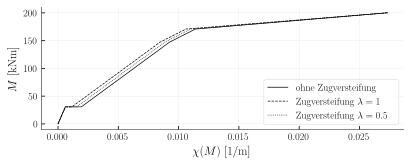

In [151]:
# | label: fig-mchi_diagramm_zugversteifung_sv14
# | fig-cap: Momenten-Krümmungs-Diagramm mit Zugversteifung

plt.plot(
    chi_to_M_array,
    M_to_chi_array / 1000,
    color="black",
    linestyle="-",
    label="ohne Zugversteifung",
)
plt.plot(
    chi_to_M_array_lambda_1,
    M_to_chi_array / 1000,
    color="black",
    linestyle="dashed",
    label="Zugversteifung $\\lambda = 1$",
)
plt.plot(
    chi_to_M_array_lambda_05,
    M_to_chi_array / 1000,
    color="black",
    linestyle="dotted",
    label="Zugversteifung $\\lambda = 0.5$",
)


plt.xlabel(f"${sp.latex(chi_M)}$ [1/m]")
plt.ylabel(f"${sp.latex(M)}$ [kNm]")
plt.legend()
plt.savefig("images/Momenten_krummung_zugversteift_SV14.svg")

plt.show()

Es zeigt sich ein leicht steiferes Verhalten im gerissenen Bereich.

## Analyse mit Fachwerksmodellen



In [152]:
import glob
import os

# Specify the folder path
file_path_fw = "docs\src\models\deformations"

# Get a list of all text files in the folder
file_paths = glob.glob(file_path_fw + "/*.txt")

# Initialize an empty dictionary to store the arrays
def_fachwerks = {}

# Open each file and read its contents
for file_path in file_paths:
    file_name = os.path.basename(file_path)
    with open(file_path, "r") as file:
        content = np.array([np.float64(line.strip()) for line in file])
        def_fachwerks[file_name] = content


<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Pascal Gitz\AppData\Local\Temp\ipykernel_5084\77353004.py:5: SyntaxWarning: invalid escape sequence '\s'
  file_path_fw = "docs\src\models\deformations"


In [153]:

# file_path_tot = "docs\src\models\deformation_results_FEM_tot_SV14.txt"
# file_path_schubbewehrung = "docs\src\models\deformation_results_FEM_schubbewehrung.txt"
# file_path_druckstrebe = "docs\src\models\deformation_results_FEM_druckstrebe.txt"
# file_path_druckgurt = "docs\src\models\deformation_results_FEM_druckgurt.txt"
# file_path_zuggurt = "docs\src\models\deformation_results_FEM_zuggurt.txt"


# # Open the file in read mode
# with open(file_path_tot, "r") as file:
#     # Read each line and convert it back to an integer
#     w_1_fachwerk_tot = np.array([float(line.strip()) for line in file])


# # Open the file in read mode
# with open(file_path_zuggurt, "r") as file:
#     # Read each line and convert it back to an integer
#     w_1_fachwerk_zuggurt = np.array([float(line.strip()) for line in file])


# # Open the file in read mode
# with open(file_path_druckgurt, "r") as file:
#     # Read each line and convert it back to an integer
#     w_1_fachwerk_druckgurt = np.array([float(line.strip()) for line in file])

# # Open the file in read mode
# with open(file_path_schubbewehrung, "r") as file:
#     # Read each line and convert it back to an integer
#     w_1_fachwerk_schubbewehrung = np.array([float(line.strip()) for line in file])

# # Open the file in read mode
# with open(file_path_druckstrebe, "r") as file:
#     # Read each line and convert it back to an integer
#     w_1_fachwerk_druckstrebe = np.array([float(line.strip()) for line in file])

Die Anwendung der Modellvorstellungen wird mit dem Modell aus @sec-fachwerk abgeschlossen, welche sich von der Beschränkung der Querschnittsbetrachtung löst. Der Kraftfluss wird mit Spannungsfeldern modelliert. Eine Einteilung in Parallelfelder und Fächer ist in @fig-spannungsfelder_sv14 gezeigt. 

![Balken mit Spannungsfeldern entsprechend dem Kraftfluss](../images/spannungsfelder_sv14.svg){#fig-spannungsfelder_sv14}

Der Neigungswinkel der Betondruckstrebe wird in Anlehnung an die @eq-v_rds_sia262 zur Bestimmung des Querkraftwiderstands von vertikaler Schubbewehrung, gemäss Ziffer 4.3.3.4.3 @SIA2013a, bestimmt. Dabei beträgt die Querschnittsfläche der Schubbewehrung:

In [154]:
n_schubbewehrung = 1
diam_schubbewehrung = 4.3 *unit.mm
n_schnittig = 2

eq_Asw_num = sp.Eq(A_sw, n_schubbewehrung * np.pi * diam_schubbewehrung**2 / 4 * n_schnittig)


eq_Asw_num.evalf(3)

                       2
A_s_w = 29.0⋅millimeter 

Die Fachwerkshöhe wird entsprechend dem Hebelarm der inneren Kräfte des Zustands 5, bzw. dem Bruchzustand gewählt.

In [155]:
eq_z_5_num.evalf(3)

z₅ = 359.0⋅millimeter

Die Fliessspannung wird mit der Zugfestigkeit $f_{su,2}$, welche dem Verhalten der Schubbewehrung entspricht, substituiert. Dies gewährleistet, dass die Schubbewehrung den elastischen Bereich verlässt. Der Querkraftwiderstand wird mit der maximal im System auftretenden Querkraft ersetzt. Abschliessend gilt $\alpha = \theta_{c3}$, was zum folgenden Neigungswinkel führt:

In [156]:
eq_V_R_sia = sp.Eq(V_R_s, A_sw / s_w * z_5 * f_su_2 * sp.cot(theta_c3))
eq_theta_c_3_min = sp.Eq(theta_c3_min, sp.solve(eq_V_R_sia, theta_c3)[0])
eq_theta_c_3_min_num = eq_theta_c_3_min.subs(
    {
        V_R_s: max(V_x_array[-1]) * unit.N,
        s_w: 30 * unit.cm,
        A_sw: eq_Asw_num.rhs,
        f_su_2: params[f_su_2],
        z_5: eq_z_5_num.rhs,
    }
)

display(eq_theta_c_3_min, eq_theta_c_3_min_num.simplify().evalf(3))

               ⎛   V_R,s⋅s_w   ⎞
θ_c3,min = acot⎜───────────────⎟
               ⎝A_s_w⋅f_su,2⋅z₅⎠

θ_c3,min = 0.214

In [157]:
sp.Eq(
    theta_c3_min,
    unit.convert_to(eq_theta_c_3_min_num.simplify().evalf(3).rhs, unit.degree).evalf(3),
)

θ_c3,min = 12.3°

Der gewählte Neigungswinkel der Felder in der @fig-spannungsfelder_sv14 orientiert sich an dem berechneten Winkel. Sowie sind die Felder parallel zueinander angeordnet.

Das Fachwerk in @fig-fachwerk_sv14 resultiert durch das Zusammenfassen der Felder zu Stäben. Um aus dem Fachwerkmodell zutreffende Verformungen zu ermitteln, gilt es den Pendelstäben passende Dehnsteifigkeiten zu zuordnen. 

![Balken mit Fachwerk durch das Zusammenfassen der Spannungsfelder](../images/fachwerk_sv14.svg){#fig-fachwerk_sv14}

Dem Zuggurt ist die Spannungs-Dehnungs-Beziehung gemäss @fig-stahlkennlinie_sv14 hinterlegt, sowie entspricht die Querschnittsfläche jener der Zugbewehrung.

Die Querschnittsfläche des Druckgurts entspricht der Höhe des plastischen Spannungsblocks des Zustands 5 multipliziert mit der Plattenstreifenbreite. Diese wird als konstant über sämtliche Stäbe des Druckgurtes angenommen. Des Weiteren wird die Spannungs-Dehnungs-Beziehung gemäss @fig-betonkennlinie_sv14 angewendet.

Die Querschnittsfläche der Druckstreben entspricht der Streifenbreite multipliziert mit der Parallelfeldbreite, gezeigt in @fig-spannungsfelder_sv14. Für die Diagonalen der nicht zentrierten Fächer ist vereinfacht die gleiche Querschnittsfläche hinterlegt. Dazu gilt die Spannungs-Dehnungs-Beziehung gemäss @fig-betonkennlinie_sv14.

Die Ständer bilden die Schubbewehrung ab. Die Querschnittsfläche resultiert aus der Anzahl an Schubbügel im entsprechenden Spannungsfeld. Es gilt die Spannungs-Dehnungs-Beziehung gemäss @fig-stahlkennlinie_sv14. Die @fig-schubbew_fw_sv14 zeigt, dass links für den Ständer 5 Schubbügel umfasst sind und rechts 11 Schubbügel. Die Steifigkeit der Ständer unterscheidet sich folglich für den linken und den rechten Breich des Balkens.

![Balken mit dargestellter Schubbewehrung und Spannungsfeldern](../images/schubbwehrung_sv14.svg){#fig-schubbew_fw_sv14}


Abschliessend lassen sich mit dem Modell Verformungen bestimmen. Für die Maximallast ist die Verformungsfigur in @fig-verformung_fachwerk_sv14 dargestellt. Die Verformung ist in der Feldmitte maximal. 


![Balken mit verformten Fachwerk](../images/Deformation_FW_sv14.svg){#fig-verformung_fachwerk_sv14}

## Vergleich der Modellvorstellungen

Abgeschlossen wird die Analyse des Versuchs mit einer Gegenüberstellung der angewendeten Methoden. 

In [158]:
# Biegemomentenverlauf und Zugversteifung

##Krümmungsverlauf
chi_x_versuch_2_zugversteifung_lamba_1 = []
chi_x_versuch_2_zugversteifung_lamba_05 = []


for M_x in M_x_array:
    chi_x_versuch_2_zugversteifung_lamba_1.append(chi_from_M_lambda_1_interpolate(M_x))
    chi_x_versuch_2_zugversteifung_lamba_05.append(
        chi_from_M_lambda_05_interpolate(M_x)
    )

# Verformung w1
w_1_m_chi_zugversteifung_1 = []
w_1_m_chi_zugversteifung_05 = []

for i in range(0, len(M_x_array)):
    w_1_m_chi_zugversteifung_1.append(
        np.trapz(M_x_array_fiktiv * chi_x_versuch_2_zugversteifung_lamba_1[i], x_array)
    )
    w_1_m_chi_zugversteifung_05.append(
        np.trapz(M_x_array_fiktiv * chi_x_versuch_2_zugversteifung_lamba_05[i], x_array)
    )


# Längszugkraft und Zugversteifung

##Krümmungsverlauf
chi_x_versuch_2_zugversteifung_lamba_1_versatz = []
chi_x_versuch_2_zugversteifung_lamba_05_versatz = []

for M_x in M_x_array_versatz:
    chi_x_versuch_2_zugversteifung_lamba_1_versatz.append(
        chi_from_M_lambda_1_interpolate(M_x)
    )
    chi_x_versuch_2_zugversteifung_lamba_05_versatz.append(
        chi_from_M_lambda_05_interpolate(M_x)
    )

## Verformung w1
w_1_m_chi_zugversteifung_1_versatz = []
w_1_m_chi_zugversteifung_05_versatz = []

for i in range(0, len(M_x_array_versatz)):
    w_1_m_chi_zugversteifung_1_versatz.append(
        np.trapz(
            M_x_array_fiktiv * chi_x_versuch_2_zugversteifung_lamba_1_versatz[i],
            x_array,
        )
    )
    w_1_m_chi_zugversteifung_05_versatz.append(
        np.trapz(
            M_x_array_fiktiv * chi_x_versuch_2_zugversteifung_lamba_05_versatz[i],
            x_array,
        )
    )


# konstante Steifigkeit
def chi_M_elastisch(M, EI):
    return M / EI


##Krümmungsverlauf
chi_x_versuch_2_konstant_gerissen = []
chi_x_versuch_2_konstant_ungerissen = []

EI_gerissen = np.float64(
    unit.convert_to(eq_EI_II_num.rhs.evalf(8), unit.N * unit.m**2)
    / unit.N
    / unit.m**2
)

EI_ungerissen = np.float64(
    unit.convert_to(eq_EI_I_num.rhs.evalf(8), unit.N * unit.m**2)
    / unit.N
    / unit.m**2
)

for M_x in M_x_array:
    chi_x_versuch_2_konstant_ungerissen.append(chi_M_elastisch(M_x, EI_ungerissen))
    chi_x_versuch_2_konstant_gerissen.append(chi_M_elastisch(M_x, EI_gerissen))

## Momenten-Krümmungs-Beziehung
chi_M_ungerissen = chi_M_elastisch(M_to_chi_array, EI_ungerissen)
chi_M_gerissen = chi_M_elastisch(M_to_chi_array, EI_gerissen)


## Verformung w1
w_1_elastisch_ungerissen = []
for i in range(0, len(M_x_array_versatz)):
    w_1_elastisch_ungerissen.append(
        np.trapz(M_x_array_fiktiv * chi_x_versuch_2_konstant_ungerissen[i], x_array)
    )


## Verformung w1
w_1_elastisch_gerissen = []
for i in range(0, len(M_x_array_versatz)):
    w_1_elastisch_gerissen.append(
        np.trapz(M_x_array_fiktiv * chi_x_versuch_2_konstant_gerissen[i], x_array)
    )

## Verformung w1 Norm
w_1_norm = []
for w in w_1_elastisch_ungerissen:
    w_1_norm.append(w_1_gerissen_norm_lamb(w))


# konstante Steifigkeit und Längszugkraft

##Krümmungsverlauf
chi_x_versuch_2_konstant_gerissen_versatz = []
chi_x_versuch_2_konstant_ungerissen_versatz = []

for M_x in M_x_array_versatz:
    chi_x_versuch_2_konstant_ungerissen_versatz.append(
        chi_M_elastisch(M_x, EI_ungerissen)
    )
    chi_x_versuch_2_konstant_gerissen_versatz.append(chi_M_elastisch(M_x, EI_gerissen))


## Verformung w1
w_1_elastisch_ungerissen_versatz = []
w_1_elastisch_gerissen_versatz = []

for i in range(0, len(M_x_array_versatz)):
    w_1_elastisch_ungerissen_versatz.append(
        np.trapz(
            M_x_array_fiktiv * chi_x_versuch_2_konstant_ungerissen_versatz[i], x_array
        )
    )
    w_1_elastisch_gerissen_versatz.append(
        np.trapz(
            M_x_array_fiktiv * chi_x_versuch_2_konstant_gerissen_versatz[i], x_array
        )
    )

## Verformung w1 Norm
w_1_norm_versatz = []
for w in w_1_elastisch_ungerissen_versatz:
    w_1_norm_versatz.append(w_1_gerissen_norm_lamb(w))


# Versuch Tue


w_1_versuch_SV14 = [
    0,
    0.28571428571428825,
    0.44642857142857295,
    0.5000000000000027,
    0.767857142857145,
    1.2500000000000018,
    3.3392857142857153,
    5.750000000000002,
    6.875000000000002,
    9.178571428571432,
    13.25,
    16.78571428571429,
    20.85714285714286,
    24.28571428571429,
    28.035714285714292,
    31.571428571428577,
    33.392857142857146,
    35.160714285714285,
    37.410714285714285,
]


F_A_versuch_SV14 = [
    0,
    5.315436241610726,
    7.087248322147644,
    8.859060402684563,
    11.516778523489918,
    14.322147651006702,
    20.375838926174495,
    28.791946308724818,
    33.221476510067106,
    41.63758389261744,
    57.583892617449656,
    69.54362416107382,
    78.40268456375838,
    84.60402684563758,
    92.57718120805369,
    99.51677852348993,
    102.02684563758389,
    103.6510067114094,
    104.53691275167785,
]

### Krümmung 

Betrachtet man zunächst die Momenten-Krümmungs-Beziehung anhand der unterschiedlichen Modellvorstellungen, aufgezeigt in der @fig-mchi_diagramm_vergleich_sv14. So zeigt sich der minimale Einfluss der Zugversteifung. Ebenso ist die nicht-linearität der Beziehung aus der Querschnittsanalyse zu erkennen.

<>:28: SyntaxWarning: invalid escape sequence '\l'
<>:35: SyntaxWarning: invalid escape sequence '\l'
<>:28: SyntaxWarning: invalid escape sequence '\l'
<>:35: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Pascal Gitz\AppData\Local\Temp\ipykernel_5084\1277756755.py:28: SyntaxWarning: invalid escape sequence '\l'
  label="Zugversteifung $\lambda = 1$",
C:\Users\Pascal Gitz\AppData\Local\Temp\ipykernel_5084\1277756755.py:35: SyntaxWarning: invalid escape sequence '\l'
  label="Zugversteifung $\lambda = 0.5$",


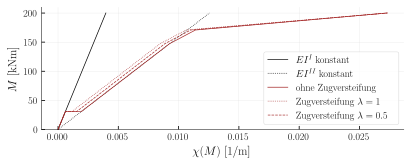

In [159]:
# | label: fig-mchi_diagramm_vergleich_sv14
# | fig-cap: Momenten-Krümmungs-Diagramm zum Vergleich der unterschiedlichen Modellvorstellungen

plt.plot(
    chi_M_ungerissen,
    M_to_chi_array / 1000,
    color="black",
    linestyle="-",
    label="$EI^{I}$ konstant",
)
plt.plot(
    chi_M_gerissen,
    M_to_chi_array / 1000,
    color="black",
    linestyle="dotted",
    label="$EI^{II}$ konstant",
)


plt.plot(
    chi_to_M_array, M_to_chi_array / 1000, color="brown", label="ohne Zugversteifung"
)
plt.plot(
    chi_to_M_array_lambda_1,
    M_to_chi_array / 1000,
    color="brown",
    linestyle="dotted",
    label="Zugversteifung $\lambda = 1$",
)
plt.plot(
    chi_to_M_array_lambda_05,
    M_to_chi_array / 1000,
    color="brown",
    linestyle="dashed",
    label="Zugversteifung $\lambda = 0.5$",
)


plt.xlabel(f"${sp.latex(chi_M)}$ [1/m]")
plt.ylabel(f"${sp.latex(M)}$ [kNm]")
plt.ylim(0, 210)
plt.legend()

plt.savefig("images/momenten_krummung_vergleich_SV14.svg")

plt.show()

Die @fig-chi_x_diagramm_vergleich_sv14 zeigt den Krümmungsverlauf für den Biegemomentenverlauf aus @fig-m_x_sv14. Dadurch dass die Bewehrung den Fliessbereich praktisch nicht erreicht, zeigt sich eine Übereinstimmung mit dem nicht-linearen Verlauf aus der Querschnittsanalyse und der konstanten gerissenen Biegesteifigkeit.

<>:21: SyntaxWarning: invalid escape sequence '\c'
<>:28: SyntaxWarning: invalid escape sequence '\l'
<>:35: SyntaxWarning: invalid escape sequence '\l'
<>:40: SyntaxWarning: invalid escape sequence '\c'
<>:21: SyntaxWarning: invalid escape sequence '\c'
<>:28: SyntaxWarning: invalid escape sequence '\l'
<>:35: SyntaxWarning: invalid escape sequence '\l'
<>:40: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Pascal Gitz\AppData\Local\Temp\ipykernel_5084\1241042265.py:21: SyntaxWarning: invalid escape sequence '\c'
  x_array, chi_M_versuch_2[-1], color="red", linestyle="-", label=f"nicht-linear $M(\chi)$"
C:\Users\Pascal Gitz\AppData\Local\Temp\ipykernel_5084\1241042265.py:28: SyntaxWarning: invalid escape sequence '\l'
  label=f"Zugversteifung $\lambda = 1$",
C:\Users\Pascal Gitz\AppData\Local\Temp\ipykernel_5084\1241042265.py:35: SyntaxWarning: invalid escape sequence '\l'
  label=f"Zugversteifung $\lambda = 0.5$",
C:\Users\Pascal Gitz\AppData\Local\Temp\ipykernel_5084\1241042265

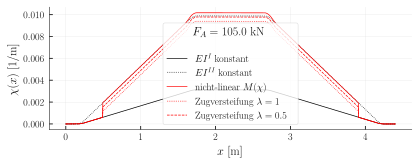

In [160]:
# | label: fig-chi_x_diagramm_vergleich_sv14
# | fig-cap: Krümmungsverlauf, mit unterschiedlichen Modellvorstellungen ohne Versatzmass

plt.plot(
    x_array,
    chi_x_versuch_2_konstant_ungerissen[-1],
    color="black",
    linestyle="-",
    label="$EI^{I}$ konstant",
)
plt.plot(
    x_array,
    chi_x_versuch_2_konstant_gerissen[-1],
    color="black",
    linestyle="dotted",
    label="$EI^{II}$ konstant",
)


plt.plot(
    x_array, chi_M_versuch_2[-1], color="red", linestyle="-", label=f"nicht-linear $M(\chi)$"
)
plt.plot(
    x_array,
    chi_x_versuch_2_zugversteifung_lamba_1[-1],
    color="red",
    linestyle="dotted",
    label=f"Zugversteifung $\lambda = 1$",
)
plt.plot(
    x_array,
    chi_x_versuch_2_zugversteifung_lamba_05[-1],
    color="red",
    linestyle="dashed",
    label=f"Zugversteifung $\lambda = 0.5$",
)


plt.xlabel(f"${sp.latex(x)}$ [m]")
plt.ylabel(f"$\chi(x)$ [1/m]")
plt.legend(title=f"$F_A =$ {Laststufen[-1]/1000} kN\n")
plt.savefig("images/krummungsverlauf_zugversteift_SV14.svg")

plt.show()

<>:26: SyntaxWarning: invalid escape sequence '\c'
<>:33: SyntaxWarning: invalid escape sequence '\l'
<>:40: SyntaxWarning: invalid escape sequence '\l'
<>:44: SyntaxWarning: invalid escape sequence '\c'
<>:26: SyntaxWarning: invalid escape sequence '\c'
<>:33: SyntaxWarning: invalid escape sequence '\l'
<>:40: SyntaxWarning: invalid escape sequence '\l'
<>:44: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Pascal Gitz\AppData\Local\Temp\ipykernel_5084\216809985.py:26: SyntaxWarning: invalid escape sequence '\c'
  label="nicht-linear $M(\chi)$",
C:\Users\Pascal Gitz\AppData\Local\Temp\ipykernel_5084\216809985.py:33: SyntaxWarning: invalid escape sequence '\l'
  label=f"Zugversteifung $\lambda = 1$",
C:\Users\Pascal Gitz\AppData\Local\Temp\ipykernel_5084\216809985.py:40: SyntaxWarning: invalid escape sequence '\l'
  label=f"Zugversteifung $\lambda = 0.5$",
C:\Users\Pascal Gitz\AppData\Local\Temp\ipykernel_5084\216809985.py:44: SyntaxWarning: invalid escape sequence '\c'
  plt.ylab

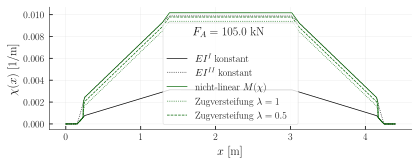

In [161]:
# | label: fig-chi_x_diagramm_laengszugkraft_sv14
# | fig-cap: Krümmungsverlauf, mit unterschiedlichen Modellvorstellungen mit Versatzmass


plt.plot(
    x_array,
    chi_x_versuch_2_konstant_ungerissen_versatz[-1],
    color="black",
    linestyle="-",
    label="$EI^{I}$ konstant",
)
plt.plot(
    x_array,
    chi_x_versuch_2_konstant_gerissen_versatz[-1],
    color="black",
    linestyle="dotted",
    label="$EI^{II}$ konstant",
)


plt.plot(
    x_array,
    chi_M_versatz_versuch_2[-1],
    color="darkgreen",
    linestyle="-",
    label="nicht-linear $M(\chi)$",
)
plt.plot(
    x_array,
    chi_x_versuch_2_zugversteifung_lamba_1_versatz[-1],
    color="darkgreen",
    linestyle="dotted",
    label=f"Zugversteifung $\lambda = 1$",
)
plt.plot(
    x_array,
    chi_x_versuch_2_zugversteifung_lamba_05_versatz[-1],
    color="darkgreen",
    linestyle="dashed",
    label=f"Zugversteifung $\lambda = 0.5$",
)

plt.xlabel(f"${sp.latex(x)}$ [m]")
plt.ylabel(f"$\chi(x)$ [1/m]")
plt.legend(title=f"$F_A =$ {Laststufen[-1]/1000} kN\n")
plt.savefig("images/krummungsverlauf_zugversteift_laengszugkraft_SV14.svg")

plt.show()

Das Versatzmass hat auf die Übereinstimmung der nicht-linearen Beziehung und der konstanten gerissenen Steifigkeit keinen Einfluss. Dies ist in der @fig-chi_x_diagramm_laengszugkraft_sv14 gezeigt. Ebenso ist der geringe Einfluss der Zugversteifung zu erkennen.

In [162]:
def plot_vergleich(border=False, querkraft=False):
    if querkraft == False:
        plt.plot(
            np.array(w_1_elastisch_ungerissen) * 1000,
            Laststufen / 1000,
            color="black",
            linestyle="-",
            label="$EI^{I}$ konstant",
        )
        plt.plot(
            np.array(w_1_elastisch_gerissen) * 1000,
            Laststufen / 1000,
            color="black",
            linestyle="dotted",
            label="$EI^{II}$ konstant",
        )
        plt.plot(
            np.array(w_1_norm) * 1000,
            Laststufen / 1000,
            color="black",
            linestyle="dashed",
            label="Abschätzung Norm",
        )

        plt.plot(
            np.array(w_1_m_chi) * 1000,
            Laststufen / 1000,
            color="red",
            label="nicht-linear $M(\chi)$",
        )
        plt.plot(
            np.array(w_1_m_chi_zugversteifung_1) * 1000,
            Laststufen / 1000,
            color="red",
            linestyle="dotted",
            label="Zugversteifung $\lambda = 1$",
        )
        plt.plot(
            np.array(w_1_m_chi_zugversteifung_05) * 1000,
            Laststufen / 1000,
            color="red",
            linestyle="dashed",
            label="Zugversteifung $\lambda = 0.5$",
        )

    if querkraft == True:
        plt.plot(
            np.array(w_1_elastisch_ungerissen_versatz) * 1000,
            Laststufen / 1000,
            color="black",
            linestyle="-",
            label="$EI^{I}$ konstant",
        )
        plt.plot(
            np.array(w_1_elastisch_gerissen_versatz) * 1000,
            Laststufen / 1000,
            color="black",
            linestyle="dotted",
            label="$EI^{II}$ konstant",
        )
        plt.plot(
            np.array(w_1_norm_versatz) * 1000,
            Laststufen / 1000,
            color="black",
            linestyle="dashed",
            label="Abschätzung Norm",
        )

        plt.plot(
            np.array(w_1_m_chi_versatz) * 1000,
            Laststufen / 1000,
            color="darkgreen",
            label="nicht-linear $M(\chi)$",
        )
        plt.plot(
            np.array(w_1_m_chi_zugversteifung_1_versatz) * 1000,
            Laststufen / 1000,
            color="darkgreen",
            linestyle="dotted",
            label="Zugversteifung $\lambda = 1$",
        )
        plt.plot(
            np.array(w_1_m_chi_zugversteifung_05_versatz) * 1000,
            Laststufen / 1000,
            color="darkgreen",
            linestyle="dashed",
            label="Zugversteifung $\lambda = 0.5$",
        )

    plt.plot(
        np.array(w_1_versuch_SV14) - w_1_versuch_SV14[0],
        F_A_versuch_SV14,
        color="blue",
        linestyle="-",
        label="Versuch SV14",
    )

    if border == True:
        plt.xlim(0, max(np.array(w_1_m_chi_versatz) * 1000))

    plt.xlabel(f"${sp.latex(w_1)}$ [mm]")
    plt.ylabel(f"${sp.latex(F_A)}$ [kN]")
    plt.legend()
    if querkraft==True:
        plt.savefig("images/durchbiegung_vergleich_SV14_versatz.svg")
    if querkraft==False:
        plt.savefig("images/durchbiegung_vergleich_SV14.svg")

    plt.show()

<>:29: SyntaxWarning: invalid escape sequence '\c'
<>:36: SyntaxWarning: invalid escape sequence '\l'
<>:43: SyntaxWarning: invalid escape sequence '\l'
<>:73: SyntaxWarning: invalid escape sequence '\c'
<>:80: SyntaxWarning: invalid escape sequence '\l'
<>:87: SyntaxWarning: invalid escape sequence '\l'
<>:29: SyntaxWarning: invalid escape sequence '\c'
<>:36: SyntaxWarning: invalid escape sequence '\l'
<>:43: SyntaxWarning: invalid escape sequence '\l'
<>:73: SyntaxWarning: invalid escape sequence '\c'
<>:80: SyntaxWarning: invalid escape sequence '\l'
<>:87: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Pascal Gitz\AppData\Local\Temp\ipykernel_5084\931655529.py:29: SyntaxWarning: invalid escape sequence '\c'
  label="nicht-linear $M(\chi)$",
C:\Users\Pascal Gitz\AppData\Local\Temp\ipykernel_5084\931655529.py:36: SyntaxWarning: invalid escape sequence '\l'
  label="Zugversteifung $\lambda = 1$",
C:\Users\Pascal Gitz\AppData\Local\Temp\ipykernel_5084\931655529.py:43: SyntaxWarn

### Verformung

Ein direkter Vergleich der Verformungen mit den gemessenen Versuchsresultate ermöglichen die Last-Verformungs-Diagramme. Dazu sind für die beschriebenen Modellvorstellungen die Verformungen für sämtliche Laststufen bestimmt worden. In @fig-last_verformung_vergleich_sv14 und @fig-last_verformung_laengszug_sv14 sind diese für die Biegemomentenverläufe aus der @fig-m_x_sv14 und der @fig-m_x_versatz_sv14 gezeigt. Welche sich in der Berücksichtigung des Versatzmasses unterscheiden. Die Verformung ist an der Stelle $w_1$ gemessen, dargestellt ist die Position in der @fig-stat_system_14_auflagerbreite.

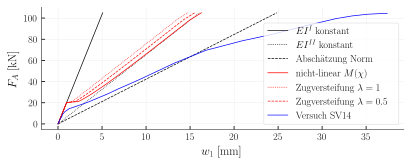

In [163]:
# | label: fig-last_verformung_vergleich_sv14
# | fig-cap: Last-Verformungs-Diagramm an der Stelle $w_1$ ohne Versatzmass

plot_vergleich()

In der @fig-last_verformung_vergleich_sv14 ist zu erkennen, dass der Verlauf der gemessenen Verformungen in etwa linear steigt. Dies verdeutlicht, dass die Zugbewehrung nicht fliesst. Aufgrund dessen sind die Resultate mit der nicht-linearen Beziehung und der konstanten gerissenen Biegesteifigkeit in etwa gleich. Auffallend ist jedoch die starke gesamte Abweichung des Modellverlaufs von den Versuchsresultaten. Das System wird mit dieser Modellierung zu steif eingeschätzt. Des Weiteren zeigt die Normabschätzung eine überraschende Genauigkeit, bzw. beschreibt diese das Tragverhalten annähernd präzise. Sowie zeigt die Modellierung mit der konstante ungerissenen Biegesteifigkeit keine Übereinstimmung mit dem Versuch.

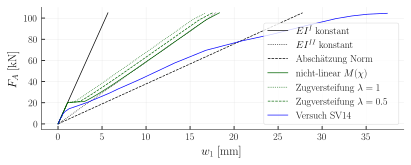

In [164]:
# | label: fig-last_verformung_laengszug_sv14
# | fig-cap: Last-Verformungs-Diagramm an der Stelle $w_1$ mit Versatzmass

plot_vergleich(querkraft=True)

Wie bereits im @sec-dreipunkt aufgezeigt, führt das Versatzmass zu einem weicheren Verhalten. Die @fig-last_verformung_laengszug zeigt sämtliche Berechnungsmethoden unter Berücksichtigung dessen. Die Modellvorstellungen zeigen eine Verbesserung hinsichtlich der Resultate aus der @fig-last_verformung_vergleich_sv14. Weiterhin liefert die Normabschätzung eine präzise Übereinstimmung mit den Messungen. Jedoch lässt sich festhalten, dass die Modellierungen mit Ausnahme der Normabschätzung keine treffenden Beschreibungen des Verformungsverhaltens darstellen.

Der Vierpunktbiegeversuch wird mit der Beschreibung der Resultate aus dem Fachwerkmodell abgeschlossen. Durch die Aufteilung der Traganteile in die einzelnen Fachwerkstäbe lassen sich Verformungsanteile aus der Schubbewehrung, der Gurte und der Betondruckstreben gesondert ermitteln, aufgezeigt ist dies in der @fig-last_verformung_fachwerk_sv14.

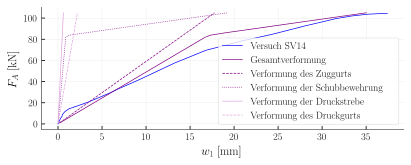

In [165]:
# | label: fig-last_verformung_fachwerk_sv14
# | fig-cap: Last-Verformungs-Diagramm an der Stelle $w_1$ mit Fachwerksmodell


Laststufen_FW = np.linspace(1000, 105 * 10**3, 50)


plt.plot(
    np.array(w_1_versuch_SV14) - w_1_versuch_SV14[0],
    F_A_versuch_SV14,
    color="blue",
    linestyle="-",
    label="Versuch SV14",
)

plt.plot(
    np.array(def_fachwerks['SV14_deformation_results_FEM_tot.txt']) * 1000,
    Laststufen_FW / 1000,
    color="purple",
    linestyle="-",
    label="Gesamtverformung",
)
plt.plot(
    np.array(def_fachwerks['SV14_deformation_results_FEM_zuggurt.txt']) * 1000,
    Laststufen_FW / 1000,
    color="purple",
    linestyle="--",
    label="Verformung des Zuggurts",
)
plt.plot(
    np.array(def_fachwerks['SV14_deformation_results_FEM_schubbewehrung.txt']) * 1000,
    Laststufen_FW / 1000,
    color="purple",
    linestyle="dotted",
    label="Verformung der Schubbewehrung",
)
plt.plot(
    np.array(def_fachwerks['SV14_deformation_results_FEM_druckstrebe.txt']) * 1000,
    Laststufen_FW / 1000,
    color="plum",
    linestyle="-",
    label="Verformung der Druckstrebe",
)
plt.plot(
    np.array(def_fachwerks['SV14_deformation_results_FEM_druckgurt.txt']) * 1000,
    Laststufen_FW / 1000,
    color="plum",
    linestyle="--",
    label="Verformung des Druckgurts",
)
# plt.plot(np.array(w_1_fachwerk_zuggurt)*1000, Laststufen/1000, color='purple',linestyle='dotted', label = 'Anteil Zuggurt')
# plt.plot(np.array(w_1_fachwerk_druckgurt)*1000, Laststufen/1000, color='purple',linestyle='dashed', label = 'Anteil Druckgurt')
# plt.plot(np.array(w_1_fachwerk_schubbewehrung)*1000, Laststufen/1000, color='black',linestyle='-', label = 'Anteil Schubbewehrung')
# plt.plot(np.array(w_1_fachwerk_druckstrebe)*1000, Laststufen/1000, color='black',linestyle='dashed', label = 'Anteil Druckstrebe')


plt.xlabel(f"${sp.latex(w_1)}$ [mm]")
plt.ylabel(f"${sp.latex(F_A)}$ [kN]")

# plt.xlim(0,max(np.array(w_1_versuch_A3V2)))

plt.legend()
plt.savefig("images/durchbiegung_vergleich_fachwerk_SV14.svg")

plt.show()

Das Fachwerkmodell liefert einen treffenden Beschrieb des Verformungsverlaufs. Es zeigt sich, dass die Schubbewehrung einen relevanten Verformungsanteil trägt. Dies erklärt die Differenzen der vorangegangen Modellvorstellungen mit den gemessenen Verformungen, da diese keine Schubverformungen berücksichtigen. Lässt man die Verformung der Schubbewehrung aussen vor, so zeigt ein Vergleich des Zuggurtverlaufs in der @fig-last_verformung_fachwerk_sv14 mit den Verläufen @fig-last_verformung_laengszug_sv14 eine Übereinstimmung. Des Weiteren ist ein Knick im Verformungsverlauf zu erkennen. Dieser ist auf das Fliessen der Schubbewehrung zurückzuführen. Die Druckstrebe und der Druckgurt spielen eine untergeordnete Rolle. 

Zu hinterfragen gilt es, dass in der @fig-last_verformung_sv14 ein Biegeversagen dokumentiert ist. Gemäss dem Fachwerkmodell stellt sich ein Versagen der Schubbewehrung ein.